<h3> Multivariate across-subject decoding of MEG evoked responses from repeated visual food cues </h3> 

By Don Enrico Esteve (P9550217B), Elizabeth Vaisman (), and Folasewa Abdulsalam(B02294068)

This notebook contains the code and results of MEG decoding in fulfillment of the Machine Learning and Neural Network project.

In [ ]:
# Elizabeth

# Define libraries necessary for Parts 1-2
from pymatreader import read_mat
import numpy as np
import os
import glob
import mne
import os   
import traceback
import re

# Define libraries necessary for Parts 3-4
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import StackingClassifier
from sklearn.utils import shuffle
from scipy.stats import wilcoxon

# Define libraries necessary for Part 5
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

# Define libraries necessary for Part 6
from sklearn.manifold import MDS

# Define seed for reproducibility
np.random.seed(42)

%matplotlib inline

<h5> Part 1: Converting preprocessed MEG data (.mat) to epoched data in MNE-Python (.fif) </h5>

<h5> 1.1. Define necessary functions </h5>

In [ ]:
# Elizabeth
def convert_mat_to_dict(file):
    """
    Function that converts a mat file to a dictionary using the pymatreader module.
    The .mat file for each subject is named datafinalLow_subXXX

    Parameters:
    file (str) - MEG recordings that underwent signal preprocessing in FieldTrip.  

    Returns: A dictionary with each Matlab field as a key
    """

    try:
        # Use pymatreader functionality to convert .mat to dict
        dict_from_mat = read_mat(file)
        return dict_from_mat
    except PermissionError as e:
        print(f"Permission error in path: {file}. Skipping. \n {e}")
    except Exception as e:
        print(f"A non premission error occured in path: {file}. \n {e}. \n Printing error traceback: \n")
        traceback.print_exc()

In [ ]:
# Elizabeth
def create_mne_info_all(sub_dict):
    """
    Function that takes information from a dictionary to populate the create_info() function of MNE.

    Parameters:
    sub_dict (dict) - A dictionary containing information from .mat files  

    Returns: An mne.Info object with information about the sensors and methods of measurement
    """
    try:
        # Take the name of each channel
        ch_names = sub_dict.get("datafinalLow").get("grad").get("label")[0:246]

        # Take only the channels of type MEG ('mag')
        ch_types = np.array(246 * ['mag'])

        # Take the sampling frequency = 1017 Hz
        sfreq = sub_dict.get("datafinalLow").get("fsample")

        # Create the mne.Info object
        mne_info = mne.create_info(ch_names, sfreq, ch_types, verbose=None)
        return mne_info
    
    except Exception as e:
        print(f"an exception has occured: {e}. \n Printing error traceback \n")
        traceback.print_exc()

In [ ]:
# Elizabeth
def convert_dict_to_epochs(sub_dict, mne_info):
    """
    Function that creates an mne.EpochsArray class that is used in the MNE-Python pipeline

    Parameters:
    sub_dict (dict) - A dictionary containing information from .mat files
    mne_info (var) - An mne.Info object with information about the sensors and methods of measurement

    Returns: An mne.EpochsArray class 
    """

    # Extract data and trial info
    data = sub_dict.get("datafinalLow").get("trial") 
    tmin = -0.3
    event_id = np.array(sub_dict.get("datafinalLow").get("trialinfo")[:, 0], dtype=int)
    
    # Identify and remove oddball trials
    oddball_idx = np.where(event_id == 8)[0]  # Ensure you get indices (using [0] to extract the indices array)
    
    # Remove oddball events from the data
    event_id = np.delete(event_id, oddball_idx)
    data = np.delete(data, oddball_idx, axis=0)  # Remove corresponding data rows (trials)
    
    # Create event onset and preceding event arrays
    event_onset = np.arange(len(event_id), dtype=int)
    event_precede = np.zeros(len(event_id), dtype=int)
    
    # Stack the event info into the correct format (onset, preceding, event_id)
    events = np.vstack((event_onset, event_precede, event_id)).T

    print(np.shape(events))  # Should now match the number of trials/data entries (~570, 3)
    print(np.shape(data))    # Ensure that data and events have consistent shapes (~570, 246, 1119)
    
    # Define event_id mapping
    event_mapping = {
        "food/short/rep1": 10, "food/medium/rep1": 12, "food/long/rep1": 14, 
        "food/short/rep2": 20, "food/medium/rep2": 22, "food/long/rep2": 24,
        "positive/short/rep1": 110, "positive/medium/rep1": 112, "positive/long/rep1": 114,
        "positive/short/rep2": 120, "positive/medium/rep2": 122, "positive/long/rep2": 124,
        "neutral/short/rep1": 210, "neutral/medium/rep1": 212, "neutral/long/rep1": 214,
        "neutral/short/rep2": 220, "neutral/medium/rep2": 222, "neutral/long/rep2": 224
    }
    
    # Create the epochs
    baseline = (-0.3, 0)
    epochs = mne.EpochsArray(
        data, mne_info, events=events, tmin=tmin, event_id=event_mapping,
        reject=None, flat=None, reject_tmin=None, reject_tmax=None,
        baseline=baseline, proj=True, on_missing='raise', metadata=None,
        selection=None, drop_log=None, raw_sfreq=None, verbose=None
    )
    
    return epochs

<h5> 1.2. Run the functions to convert .mat files to class mne.EpochsArray </h5>

In [ ]:
# Elizabeth
# Define directory to where subject data are kept. Add the part of the file name common to all files
directory = "Z:/Don/ML_Project/Evoked_responses/datafinalLow*" 

# Initialize the iteration count
iteration = 0

for file in glob.iglob(directory):
    # Take the unique part of the file - subject number XXX
    subject_num = re.split(r"[_.]+",file)[3]

    # Convert .mat to dict
    sub_dict = convert_mat_to_dict(file)
    
    # Create mne.Info object only once as it is same across subjects
    if iteration == 0:
        mne_info = create_mne_info_all(sub_dict)

    # Create mne.EpochsArray class
    epochs = convert_dict_to_epochs(sub_dict, mne_info)

    # Save as FIF files which is the standard format readable in MNE-Python
    save_in_path = os.path.join("Z:/Don/ML_Project/Evoked_fif", f"{subject_num}_epo.fif")
    epochs.save(save_in_path, overwrite=True)

    # Change the iteration to prevent the creation of new mne.Info object
    iteration = 1

<h3> Part 2: Create numpy arrays from epoched data </h3>

Creating data of shape (n_epochs, n_channels, n_times) where n_channels = 246 and n_times = 1119

<h5> 2.1. Define necessary functions </h5>

For making numpy arrays for multi-class classification 

In [9]:
# Elizabeth
def split_list(lst, chunk_size):
    """
    Helper function to split a list into chunks of a specified size.
    Used for grouping the conditions based on event ID.

    Parameters:
    lst (list) - List to be splitted
    chunk_size (int) - Number of elements in the output

    Returns: A list with n=chunk_size elements
    """

    # Use a list comprehension to create chunks
    # For each index 'i' in the range from 0 to the length of the list with step 'chunk_size'
    # Slice the list from index 'i' to 'i + chunk_size'
    return [lst[i:i + chunk_size] for i in range(0, len(lst), chunk_size)]

In [10]:
# Elizabeth
def stack_lags_of_conditions(epochs, conditions):
    """
    Takes the information from each lag duration of each category * repetition and concatenates them.

    Parameters:
    epochs (var): Instance of Epochs class
    conditions (list): Information from split_list(). Corresponds to category * repetition

    Returns: A three-dimensional numpy array (np.ndarray)
    """
    
    # The indices 0,1,2 are with respect to how the conditions were originally ordered:
    # e.g. Food_Short_1, Food_Medium_1, Food_Long_1, ...
    short = epochs[conditions[0]].get_data()
    medium = epochs[conditions[1]].get_data()
    long = epochs[conditions[2]].get_data()

    # Vertically stack to create 3D array
    stacked_over_trial = np.vstack((short, medium, long))
    return stacked_over_trial

<h5> 2.2. Create numpy arrays for multi-class classification </h5>

Concatenate the lags for each condition, for each subject

In [ ]:
# Elizabeth
# Locate directory of the epoched (.fif) files
directory = "Z:/Don/ML_Project/Evoked_fif/sub*"

# Define file names for each condition
multi_class_conds = ['food_1.npy', 'food_2.npy', 'positive_1.npy', 'positive_2.npy', 'neutral_1.npy', 'neutral_2.npy']

# Set directory where the numpy arrays (.npy) are to be saved
directory_save = "Z:\Don\ML_Project\Window files\M200\evoked_cond_concat_binary_and_multiclass/sub*"

# Get and sort the list of files
subject_files = sorted(glob.glob(directory))
save_folders = sorted(glob.glob(directory_save))

# Ensure the lengths match before iterating
assert len(subject_files) == len(save_folders), "Number of files and saving directories do not match."

# Perform for each subject
for file, saving_folder in zip(subject_files, save_folders):

    # Create instance of Epochs class
    epochs = mne.read_epochs(file)

    # Crop only the time of interest (0-0.8 s)
    # We can also change this to the time window of each component 
    # M100: 0.118-0.155 s, M200: 0.171-0.217 s, M300: 0.239-0.332 s, LPP: 0.350-0.800 s                
    epochs_toi = epochs.crop(tmin=0.171, tmax=0.217)

    # Create a list of all 18 conditions 
    conditions = list(epochs_toi.event_id.keys())

    # Create a list of 6 conditions (Food_1, Food_2, Positive_1, Positive_2, Neutral_1, Neutral_2)
    grouped_conditions = split_list(conditions, 3)
    
    # Save numpy arrays
    for group, cond_names in zip(grouped_conditions, multi_class_conds):
        concat_condition_data = stack_lags_of_conditions(epochs_toi, group)
        path = os.path.join(saving_folder, cond_names)
        np.save(path, concat_condition_data)

Other multi-class classification variants:
- 3-class classification (Food, Positive, Neutral)
- 4-class classification (Food1, Food2, Nonfood1, Nonfood2)

<h5> 2.3. Create numpy arrays for binary classification </h5>

Concatenate the average across lags and image categories for each condition, for each subject

In [ ]:
# Locate directory of the epoched (.fif) files
# directory = "Z:/Don/ML_Project/evoked_cond_concat_binary_and_multiclass/sub*"
directory = "Z:\Don\ML_Project\Window files\M200\evoked_cond_concat_binary_and_multiclass/sub*"

# Define file names for each condition
X_class_conds = ['food_1.npy', 'positive_1.npy', 'neutral_1.npy', 'food_2.npy', 'positive_2.npy', 'neutral_2.npy']

# Set directory where the numpy arrays (.npy) are to be saved
directory_save = "Z:\Don\ML_Project\Window files\M200\evoked_cond_concat_binary_and_multiclass/sub*"

# Get and sort the list of files
subject_files = sorted(glob.glob(directory))
save_folders = sorted(glob.glob(directory_save))

# Ensure the lengths match before iterating
assert len(subject_files) == len(save_folders), "Number of files and saving directories do not match."

# Perform for each subject, sorted alphabetically
for file, saving_folder in zip(subject_files, save_folders):
    
    # Initialize lists to hold the data arrays for neutral and positive conditions
    food_1 = []
    positive_1 = []
    neutral_1 = []
    food_2 = []
    positive_2 = []
    neutral_2 = []

    # Load the respective .npy files for the current subject
    food_1_path = os.path.join(file, 'food_1.npy')
    positive_1_path = os.path.join(file, 'positive_1.npy')
    neutral_1_path = os.path.join(file, 'neutral_1.npy')
    food_2_path = os.path.join(file, 'food_2.npy')
    neutral_2_path = os.path.join(file, 'neutral_2.npy')
    positive_2_path = os.path.join(file, 'positive_2.npy')
    
    # Check if the files exist for the current subject
    if os.path.exists(food_1_path) and os.path.exists(neutral_1_path) and os.path.exists(positive_1_path):
        food_1 = np.load(food_1_path)
        neutral_1 = np.load(neutral_1_path)
        positive_1 = np.load(positive_1_path)
        print(f"Loaded food_1.npy, neutral_1.npy, and positive_1.npy for subject {file}")

        food_2 = np.load(food_2_path)
        neutral_2 = np.load(neutral_2_path)
        positive_2 = np.load(positive_2_path)
        print(f"Loaded food_2.npy, neutral_2.npy and positive_2.npy for subject {file}")
    else:
        print(f"Missing .npy files for subject {file}, skipping...")
        continue  # Skip to the next subject if the files are missing

    # Stack the data arrays along the first axis (this can be adjusted depending on your needs)
    food = np.vstack([food_1, food_2])
    nonfood = np.vstack([positive_1, neutral_1, positive_2, neutral_2])

    nonfood_1 = np.vstack([positive_1, neutral_1])
    nonfood_2 = np.vstack([positive_2, neutral_2])

    positive = np.vstack([positive_1, positive_2])
    neutral = np.vstack([neutral_1, neutral_2])

    pres_1 = np.vstack([food_1, positive_1, neutral_1])     
    pres_2 = np.vstack([food_2, positive_2, neutral_2])     
    
    # Save the stacked data to the corresponding save folder
    save_path = os.path.join(saving_folder, 'food.npy')
    np.save(save_path, food)
    
    save_path = os.path.join(saving_folder, 'nonfood.npy')
    np.save(save_path, nonfood)

    save_path = os.path.join(saving_folder, 'nonfood_1.npy')
    np.save(save_path, nonfood_1)
    
    save_path = os.path.join(saving_folder, 'nonfood_2.npy')
    np.save(save_path, nonfood_2)

    save_path = os.path.join(saving_folder, 'positive.npy')
    np.save(save_path, positive)
    
    save_path = os.path.join(saving_folder, 'neutral.npy')
    np.save(save_path, neutral)

    save_path = os.path.join(saving_folder, 'pres_1.npy')
    np.save(save_path, pres_1)
    
    save_path = os.path.join(saving_folder, 'pres_2.npy')
    np.save(save_path, pres_2)

    print(f"Saved stacked data for subject {file} to {save_path}")

<h3> Part 3: Data preprocessing for machine learning </h3>

- Temporal decimation - reducing time points and computation time
- Pseudo-trial calculation - reducing signal-to-noise ratio inherent in raw (single) trials
- Principal component analysis - reducing channels and dimensionality

<h5> 3.1. Temporal decimation </h5>

Define a function for temporal decimation

In [41]:
# Don
# Function for temporal decimation

def decimate_data_trimmed(data, bin_size_ms=20, sampling_rate_hz=1000):
    """
    Takes a 3D numpy array and reduces the length of the last axis (time) by averaging.

    Parameters:
    data (np.ndarray): A 3D matrix of shape (n_epochs, n_channels, n_times)
    bin_size_ms (int): The length of time (in ms) within which each time point is consecutively averaged. Default is 20 ms.
    sampling_rate_hz (int): The sampling frequency (in Hz). Default is 1000 Hz

    Returns: 
    A 3D numpy array of shape n_epochs, n_channels, n_times with the last axis reduced.
    """

    bin_size_samples = int(bin_size_ms * sampling_rate_hz / 1000)
    
    # Get the length of each axis of the 3D matrix
    n_epochs, n_channels, n_times = data.shape
    
    # Calculate how many time points to trim
    trim_samples = n_times % bin_size_samples
    if trim_samples != 0:
        # Trim the last `trim_samples` time points - Last 9 samples
        data = data[:, :, :-trim_samples]
    
    # Now the number of time points is divisible by the bin size
    n_times_trimmed = data.shape[2]
    
    # Reshape and average the data over bins
    reshaped_data = data.reshape(n_epochs, n_channels, n_times_trimmed // bin_size_samples, bin_size_samples)
    decimated_data = reshaped_data.mean(axis=-1)
    
    return decimated_data

Perform temporal decimation

With the default bin size of 20 ms, the 800 original post-stimulus time points is reduced to 40 time points.

In [ ]:
# Don
# Define where input data are located
# root_dir = "Z:/Don/ML_Project/evoked_cond_concat_binary_and_multiclass"
root_dir = "Z:\Don\ML_Project\RSA files\M100_conds_npy"

# Directory to save the processed files (this directory contains subfolders named sub_XXX)
# output_dir = "Z:/Don/ML_Project/Preprocessed_data"
output_dir = "Z:\Don\ML_Project\RSA files\M100_conds_dec"

# Iterate through each subject (each having a sub_XXX directory)
subject_dirs = sorted([sub_dir for sub_dir in os.listdir(root_dir) if sub_dir.startswith('sub_') and os.path.isdir(os.path.join(root_dir, sub_dir))])

for sub_dir in subject_dirs:
    sub_dir_path = os.path.join(root_dir, sub_dir)
    
    # Create the corresponding subfolder in the output directory
    output_subfolder = os.path.join(output_dir, sub_dir)
    os.makedirs(output_subfolder, exist_ok=True)
    
    # Iterate through each .npy file in the sub_XXX directory
    for file_name in os.listdir(sub_dir_path):
        if file_name.endswith('.npy'):
            file_path = os.path.join(sub_dir_path, file_name)
            
            # Load the data
            data = np.load(file_path)
            
            # Process the data with decimate_data_trimmed() function
            decimated_data = decimate_data_trimmed(data, bin_size_ms=2)
            
            # Save the decimated data to the respective subfolder in the output directory
            decimated_file_name = file_name.replace('.npy', '_dec.npy')
            decimated_file_path = os.path.join(output_subfolder, decimated_file_name)
            np.save(decimated_file_path, decimated_data)

            # Print for tracking purposes
            print(f"Processed and saved: {decimated_file_name} in {output_subfolder}")

Check data shape and values after temporal decimation

In [43]:
# Don
# Load decimated data for a sample condition and sample subject
# decimated_data_sample = np.load("Z:/Don/ML_Project/Preprocessed_data/sub_054/food_dec.npy")
decimated_data_sample = np.load("Z:/Don/ML_Project/RSA files/M100_conds_dec/sub_054/food_short_rep2_dec.npy")

# Display the data shape and data values (of the first matrix as sample)
display(decimated_data_sample.shape)
display(decimated_data_sample[0])

(32, 246, 19)

array([[ 1.85926290e-14,  2.87937526e-14,  3.87959708e-14, ...,
         2.29037831e-13,  2.23403225e-13,  2.11506200e-13],
       [-2.44878583e-15,  6.07513206e-15,  1.64621010e-14, ...,
         1.09258638e-13,  1.00648629e-13,  9.11095201e-14],
       [-6.48188643e-14, -6.11045807e-14, -5.52497365e-14, ...,
         1.96440276e-13,  1.93872879e-13,  1.86402665e-13],
       ...,
       [-1.05230457e-13, -1.08380739e-13, -1.10972070e-13, ...,
         2.65931550e-13,  2.99634463e-13,  3.24328116e-13],
       [-1.25998922e-13, -1.14511990e-13, -9.96442715e-14, ...,
         1.19155838e-13,  1.32082476e-13,  1.43634148e-13],
       [-2.80448692e-13, -2.72015253e-13, -2.56204902e-13, ...,
         7.10338770e-14,  8.71014822e-14,  1.00363880e-13]],
      shape=(246, 19))

<h5> 3.2 Pseudo-trial calculation </h5>

Define a function for pseudotrial calculation without permutation functionality

We define a pseudotrial as the average of raw (single) trials contained in a group.

In [44]:
# Don
def generate_pseudo_trials(data, n_groups=10):
    """
    Function that computes pseudo-trials from raw (single) trials.
    For each condition, raw trials (n=~20-30) were randomly placed in 5 groups then averaged. 

    Parameters:
    data (np.ndarray): A 3D matrix of shape (n_epochs, n_channels, n_times)
    n_groups (int): Number of pseudo-trials to be defined. Default value is 5. Must not be larger than 20.

    Returns: A 3D numpy array of shape n_epochs, n_channels, n_times with the first axis reduced to n_groups.
    """
    # Ensure n_groups is not larger than 20 (minimum number of single trials in a condition)
    assert n_groups <= 20, f"n_groups must not be larger than 20, but got {n_groups}"

    # Get the length of each axis of the 3D matrix
    n_epochs, n_channels, n_times = data.shape

    # Split the epochs into n_groups
    group_size = n_epochs // n_groups
    groups = [np.arange(i * group_size, (i + 1) * group_size) for i in range(n_groups)]
    
    # Handle any remaining epochs (in case n_epochs is not divisible by n_groups)
    if n_epochs % n_groups != 0:
        groups[-1] = np.concatenate([groups[-1], np.arange(n_groups * group_size, n_epochs)])

    # Step 2: Average epochs within each group to create pseudo-trials
    group_pseudo_trials = []
    for group in groups:
        pseudo_trial = np.mean(data[group, :, :], axis=0)  # Average over the epochs in the group
        group_pseudo_trials.append(pseudo_trial)

    # Step 3: Stack the pseudo-trials into a 3D array (n_groups x n_channels x n_times)
    return np.stack(group_pseudo_trials, axis=0)

Perform pseudo-trial calculation

With the default n_groups of 10, we create 10 pseudo-trials for each condition for each subject

In [ ]:
# Don
# Define where input data are located
# root_dir = "Z:/Don/ML_Project/Preprocessed_data"
root_dir = "Z:\Don\ML_Project\RSA files\M100_conds_dec"

# Directory to save the processed files (this directory contains subfolders named sub_XXX)
# output_dir = "Z:/Don/ML_Project/Preprocessed_dec_pseudo"
output_dir = "Z:\Don\ML_Project\RSA files\M100_conds_pseudo"

# Iterate through each subject (each having a sub_XXX directory)
subject_dirs = sorted([sub_dir for sub_dir in os.listdir(root_dir) if sub_dir.startswith('sub_') and os.path.isdir(os.path.join(root_dir, sub_dir))])

for sub_dir in subject_dirs:
    sub_dir_path = os.path.join(root_dir, sub_dir)
    
    # Create the corresponding subfolder in the output directory
    output_subfolder = os.path.join(output_dir, sub_dir)
    os.makedirs(output_subfolder, exist_ok=True)
    
    # Iterate through each .npy file in the sub_XXX directory
    for file_name in os.listdir(sub_dir_path):
        if file_name.endswith('.npy'):
            file_path = os.path.join(sub_dir_path, file_name)
                
            # Load the data
            data = np.load(file_path)
            
            # Process the data with generate_pseudo_trials() function
            pseudo_trial = generate_pseudo_trials(data, n_groups=10)
                        
            # Save the pseudo_trial to the respective subfolder in the output directory
            pseudo_trial_file_name = file_name.replace('.npy', '_pseudo.npy')
            pseudo_trial_file_path = os.path.join(output_subfolder, pseudo_trial_file_name)
            np.save(pseudo_trial_file_path, pseudo_trial)

            print(f"Processed and saved: {pseudo_trial_file_name} in {output_subfolder}")

Check data shape and data values after pseudo-trial calculation

In [47]:
# Don
# Load pseudo_trial for a sample condition and sample subject
pseudo_trial_data_sample = np.load("Z:/Don/ML_Project/Preprocessed_dec_pseudo/sub_054/food_dec_pseudo.npy")

# Display the data shape and data values (of the first matrix as sample)
display(pseudo_trial_data_sample.shape)
display(pseudo_trial_data_sample[0])

(10, 246, 19)

array([[-8.62272440e-14, -8.17158508e-14, -7.60382155e-14, ...,
        -4.43349893e-14, -4.35386415e-14, -4.13935634e-14],
       [ 4.37800600e-14,  4.51318814e-14,  4.57379653e-14, ...,
         6.25419937e-14,  6.56361833e-14,  6.81463593e-14],
       [-1.79936639e-14, -1.62080237e-14, -1.40542518e-14, ...,
         6.09191935e-14,  7.00681489e-14,  7.98964889e-14],
       ...,
       [-9.08428377e-14, -9.46268913e-14, -9.61016504e-14, ...,
         5.91185523e-14,  7.61092561e-14,  9.20492610e-14],
       [-8.30410827e-14, -8.39683249e-14, -8.42475995e-14, ...,
        -9.73876688e-15,  5.24863369e-15,  2.15512450e-14],
       [-6.96077413e-14, -7.93496133e-14, -8.86672989e-14, ...,
        -7.57751817e-14, -6.36782876e-14, -5.01536261e-14]],
      shape=(246, 19))

<h5> 3.3. Principal Component Analysis </h5>

Define a function that performs PCA using all time points, i.e. the "first approach" of Hatamimajoumerd et al. (2019)

In [19]:
# Don
def perform_pca_with_pseudotrials(data, n_components=10):
    """
    Perform PCA on a 3D array across all time points for each pseudo-trial independently.
    
    Parameters:
    data (np.ndarray): Input data of shape (n_pseudotrials, n_channels, n_timepoints).
    n_components (int or None): Number of PCA components to retain. If None, all components are retained. Default value is 10.
    
    Returns:
    pca_transformed_data (np.ndarray): Transformed data of shape (n_pseudotrials, n_components, n_timepoints).
    pca_models (list): List of PCA objects for each pseudo-trial (useful for inspecting PCA components).
    """
    n_pseudotrials, n_channels, n_timepoints = data.shape

    # Prepare to store the transformed data and PCA models
    pca_transformed_data = []
    pca_models = []

    # Apply PCA for each pseudo-trial independently
    for trial in range(n_pseudotrials):
        # Flatten the data for the current pseudo-trial (n_channels x n_timepoints -> n_features)
        trial_data = data[trial, :, :].reshape(n_channels, n_timepoints).T
        
        # Apply PCA
        pca = PCA(n_components=n_components)
        transformed = pca.fit_transform(trial_data)
        
        # Store the transformed data and PCA model
        pca_transformed_data.append(transformed.T)  # Transpose back to (n_components x n_timepoints)
        pca_models.append(pca)
    
    # Stack transformed data back into a 3D array (n_pseudotrials x n_components x n_timepoints)
    pca_transformed_data = np.stack(pca_transformed_data, axis=0)

    return pca_transformed_data, pca_models

Perform PCA

With the default n_components of 10, we reduce the 246 channels to 10 components for each condition for each subject

In [ ]:
# Don
# Define where input data are located
# root_dir = "Z:/Don/ML_Project/Preprocessed_dec_pseudo"
root_dir = "Z:\Don\ML_Project\RSA files\M100_conds_npy"

# Directory to save the processed files (this directory contains subfolders named sub_XXX)
# output_dir = "Z:/Don/ML_Project/Preprocessed_dec_pseudo_PCA"
output_dir = "Z:\Don\ML_Project\RSA files\M100_conds_PCA"

# Iterate through each subject (each having a sub_XXX directory)
subject_dirs = sorted([sub_dir for sub_dir in os.listdir(root_dir) if sub_dir.startswith('sub_') and os.path.isdir(os.path.join(root_dir, sub_dir))])

for sub_dir in subject_dirs:
    sub_dir_path = os.path.join(root_dir, sub_dir)
    
    # Create the corresponding subfolder in the output directory
    output_subfolder = os.path.join(output_dir, sub_dir)
    os.makedirs(output_subfolder, exist_ok=True)
    
    # Iterate through each .npy file in the sub_XXX directory
    for file_name in os.listdir(sub_dir_path):
        if file_name.endswith('.npy'):
            file_path = os.path.join(sub_dir_path, file_name)
                
            # Load the data
            data = np.load(file_path)
            
            # Process the data with perform_pca_with_pseudotrials() function
            data_pca, data_models = perform_pca_with_pseudotrials(data, n_components=30)
            
            # Save the data_pca to the respective subfolder in the output directory
            # data_models is not really required for the machine learning pipeline
            data_pca_file_name = file_name.replace('.npy', '_pca.npy')
            data_pca_file_path = os.path.join(output_subfolder, data_pca_file_name)
            np.save(data_pca_file_path, data_pca)

            print(f"Processed and saved: {data_pca_file_name} in {output_subfolder}")

Check data shape and data values after pseudo-trial calculation

In [ ]:
# Don
# Load data applied with PCA for a sample condition and sample subject
# PCA_data_sample = np.load("Z:/Don/ML_Project/Preprocessed_dec_pseudo_PCA/sub_054/food_dec_pseudo_PCA.npy")
PCA_data_sample = np.load("Z:/Don/ML_Project/RSA files/M100_conds_PCA/sub_054/positive_medium_rep1_pca.npy")

# Display the data shape and data values (of the first matrix as sample)
display(PCA_data_sample.shape)

<h3> Part 4: Training and testing </h3>

Two machine learning tasks are performed with varying conditions:
- Binary classification - classify between Food and Nonfood
- Multi-class classification - classify among Food1, Food2, Positive1, Positive2, Neutral1, and Neutral2

For both tasks, the same meta-model architecture using stacked generalization (ensemble classifier) will be used.

<h5> 4.1. Prepare input to classifier </h5>

Create a 2D array of shape (features, samples)

Function common to both tasks that helps to reshape data for classification

In [2]:
# Don

def reshape_data(data_dict, conditions):
    """
    Reshape data from multiple subjects and conditions for classification.

    Parameters:
    data_dict (dict): keys are subject identifiers (e.g., "subject1") and values are dictionaries, with condition names as keys and 3D numpy arrays as values. 
    conditions (list of str): names of conditions to include.

    Returns:
    X (2D np.ndarray): Array of shape (total_pseudotrials, n_features) where n_features = n_channels * n_times.
    y (1D np.ndarray): Array of shape (total_pseudotrials,), containing labels for each pseudo-trial.
    groups (1D np.ndarray): Array of shape (total_pseudotrials,), containing subject identifiers for each pseudo-trial.
    """

    X, y, groups = [], [], []  # Initialize lists to store reshaped data, labels, and groups

    # Iterate over subjects and their data
    for subject, subject_data in data_dict.items():
        # Iterate over conditions and their indices
        for cond_idx, condition in enumerate(conditions):
            # Check if the condition exists for the current subject
            if condition in subject_data:
                data = subject_data[condition]  # Get the data for the current condition
                n_pseudotrials = data.shape[0]  # Number of pseudo-trials

                # Reshape the data: (n_pseudotrials, n_channels * n_times)
                X.append(data.reshape(n_pseudotrials, -1))

                # Append the condition label for each pseudo-trial
                y.extend([cond_idx] * n_pseudotrials)

                # Append the subject identifier for each pseudo-trial
                groups.extend([subject] * n_pseudotrials)

    # Convert lists to numpy arrays and return
    return np.vstack(X), np.array(y), np.array(groups)

Define the base directory and conditions

In [56]:
# Define where input data are located
# base_dir = "Z:\Don\ML_Project\Window files\M100\Preprocessed_dec_pseudo_PCA"

# Define the conditions for binary classification
binary_conditions_12 = [
    "pres_1_dec_pseudo_PCA", "pres_2_dec_pseudo_PCA",
]

binary_conditions_FN = [
    "food_dec_pseudo_PCA", "nonfood_dec_pseudo_PCA",
]

binary_conditions_FP = [
    "food_dec_pseudo_PCA", "positive_dec_pseudo_PCA",
]

binary_conditions_FT = [
    "food_dec_pseudo_PCA", "neutral_dec_pseudo_PCA",
]

binary_conditions_PT = [
    "positive_dec_pseudo_PCA", "neutral_dec_pseudo_PCA",
]

binary_conditions_FN1 = [
    "food_1_dec_pseudo_PCA", "nonfood_1_dec_pseudo_PCA",
]

binary_conditions_FN2 = [
    "food_2_dec_pseudo_PCA", "nonfood_2_dec_pseudo_PCA",
]

binary_conditions_F12 = [
    "food_1_dec_pseudo_PCA", "food_2_dec_pseudo_PCA",
]

binary_conditions_P12 = [
    "positive_1_dec_pseudo_PCA", "positive_2_dec_pseudo_PCA",
]

binary_conditions_T12 = [
    "neutral_1_dec_pseudo_PCA", "neutral_2_dec_pseudo_PCA",
]

binary_conditions_N12 = [
    "nonfood_1_dec_pseudo_PCA", "nonfood_2_dec_pseudo_PCA",
]


# Define the conditions for multi-class classification
multi_conditions_3A = [
    "food_dec_pseudo_PCA", "positive_dec_pseudo_PCA", "neutral_dec_pseudo_PCA"
]

multi_conditions_3B = [
    "food_1_dec_pseudo_PCA", "positive_1_dec_pseudo_PCA", "neutral_1_dec_pseudo_PCA"
]

multi_conditions_3C = [
    "food_2_dec_pseudo_PCA", "positive_2_dec_pseudo_PCA", "neutral_2_dec_pseudo_PCA"
]

multi_conditions_4A = [
    "food_1_dec_pseudo_PCA", "food_2_dec_pseudo_PCA",
    "nonfood_1_dec_pseudo_PCA", "nonfood_2_dec_pseudo_PCA",
]

multi_conditions_4B = [
    "food_1_dec_pseudo_PCA", "food_2_dec_pseudo_PCA",
    "positive_1_dec_pseudo_PCA", "positive_2_dec_pseudo_PCA",
]

multi_conditions_4C = [
    "food_1_dec_pseudo_PCA", "food_2_dec_pseudo_PCA",
    "neutral_1_dec_pseudo_PCA", "neutral_2_dec_pseudo_PCA",
]

multi_conditions_6 = [
    "food_1_dec_pseudo_PCA", "food_2_dec_pseudo_PCA",
    "positive_1_dec_pseudo_PCA", "positive_2_dec_pseudo_PCA",
    "neutral_1_dec_pseudo_PCA", "neutral_2_dec_pseudo_PCA"
]

<h5> 4.2. Perform binary classification </h5>

At this point, the features (X) have a shape of (2520, 550) and the labels have a shape of (2520,)

The feature rows are defined as n_subjects x n_pseudotrials x n_conditions (42 x 10 x 6) = 2520

The feature columns are defined as n_components x n_times (10 x 55) = 550

In [ ]:
# Define different categorization sets for multi-class classification
list_binary_accuracies = []

binary_conditions = [binary_conditions_FN, binary_conditions_FP, binary_conditions_FT, 
                     binary_conditions_PT, binary_conditions_FN1, binary_conditions_FN2, 
                     binary_conditions_F12, binary_conditions_P12, binary_conditions_T12,
                     binary_conditions_N12, binary_conditions_12]

# Loop through each condition set
for binary_conditions_set in binary_conditions:
    print(f"Running with categorization: {binary_conditions_set}")

    # Load the data for the current categorization set
    subjects_data = {}
    for subject in os.listdir(base_dir):
        subject_dir = os.path.join(base_dir, subject)
        if os.path.isdir(subject_dir):
            subject_data = {}
            for condition in binary_conditions_set:  # Use the current categorization set
                condition_file = os.path.join(subject_dir, f'{condition}.npy')
                if os.path.exists(condition_file):
                    subject_data[condition] = np.load(condition_file)
            subjects_data[subject] = subject_data

    # Prepare the data
    X, y, groups = reshape_data(subjects_data, binary_conditions_set)

    # Define the base classifiers
    base_classifiers = [
        ('svm', SVC(probability=True, random_state=42)),
        ('lda', LDA()),
        ('gnb', GaussianNB())
    ]

    # Final classifier (Logistic Regression) with default parameters
    final_classifier = LogisticRegression(random_state=42)

    # Create the stacking classifier without hyperparameter optimization
    stacking_clf = StackingClassifier(
        estimators=base_classifiers,
        final_estimator=final_classifier
    )

    # Leave-One-Subject-Out Cross Validation
    logo = LeaveOneGroupOut()
    binary_accuracies = []

    for train_idx, test_idx in logo.split(X, y, groups):
        # Extract the current test subject
        test_subject = groups[test_idx][0]
        print(f"Testing on subject: {test_subject}")
        
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Shuffle the training data (but do not shuffle the test data)        # TRY TO ADD SHUFFLE IF ACCURACY INCREASES
        # X_train, y_train = shuffle(X_train, y_train, random_state=42)
        
        # Standardize the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Build the stacking classifier with default base models
        stacking_clf.fit(X_train, y_train)
        
        # Test the classifier
        y_pred = stacking_clf.predict(X_test)
        binary_accuracy = accuracy_score(y_test, y_pred)
        binary_accuracies.append(binary_accuracy)
        print(f"Subject {test_subject} accuracy: {binary_accuracy:.2f}\n")

    # List the lists
    list_binary_accuracies.append(binary_accuracies)

    # Overall accuracy
    print(f"Mean accuracy: {np.mean(binary_accuracies):.2f}")

np.save("Z:/Don/ML_Project/Results/list_binary_accuracies_M100_2_10_13.npy", list_binary_accuracies)

<h5> 4.3. Perform multi-class classification </h5>

In [ ]:
# Define different categorization sets for multi-class classification
list_multi_accuracies = []
multi_conditions = [multi_conditions_3A, multi_conditions_3B, multi_conditions_3C,
                    multi_conditions_4A, multi_conditions_4B, multi_conditions_4C,
                    multi_conditions_6]

# Loop through each condition set
for multi_conditions_set in multi_conditions:
    print(f"Running with categorization: {multi_conditions_set}")

    # Load the data for the current categorization set
    subjects_data = {}
    for subject in os.listdir(base_dir):
        subject_dir = os.path.join(base_dir, subject)
        if os.path.isdir(subject_dir):
            subject_data = {}
            for condition in multi_conditions_set:  # Use the current categorization set
                condition_file = os.path.join(subject_dir, f'{condition}.npy')
                if os.path.exists(condition_file):
                    subject_data[condition] = np.load(condition_file)
            subjects_data[subject] = subject_data

    # Prepare the data
    X, y, groups = reshape_data(subjects_data, multi_conditions_set)

    # Define the base classifiers
    base_classifiers = [
        ('svm', SVC(probability=True, random_state=42)),
        ('lda', LDA()),
        ('gnb', GaussianNB())
    ]

    # Final classifier (Logistic Regression) with default parameters
    final_classifier = LogisticRegression(random_state=42)

    # Create the stacking classifier without hyperparameter optimization
    stacking_clf = StackingClassifier(
        estimators=base_classifiers,
        final_estimator=final_classifier
    )

    # Leave-One-Subject-Out Cross Validation
    logo = LeaveOneGroupOut()
    multi_accuracies = []

    for train_idx, test_idx in logo.split(X, y, groups):
        # Extract the current test subject
        test_subject = groups[test_idx][0]
        print(f"Testing on subject: {test_subject}")
        
        X_train, X_test = X[train_idx], X[test_idx] # (n_subjects*n_conditions*n_pseudotrials, n_components*n_times), # (n_conditions*n_pseudotrials, n_components*n_times),
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Standardize the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Build the stacking classifier with default base models
        stacking_clf.fit(X_train, y_train)
        
        # Test the classifier
        y_pred = stacking_clf.predict(X_test)
        multi_accuracy = accuracy_score(y_test, y_pred)
        multi_accuracies.append(multi_accuracy)
        print(f"Subject {test_subject} accuracy: {multi_accuracy:.4f}\n")

    # List the lists
    list_multi_accuracies.append(multi_accuracies)

    # Overall accuracy for the current categorization set
    print(f"Mean accuracy for {multi_conditions_set}: {np.mean(multi_accuracies):.4f}\n")

np.save("Z:/Don/ML_Project/Results/list_multi_accuracies_M100_2_10_13.npy", list_multi_accuracies)

<h5> 4.4. Perform non-parametric statistics on accuracy </h5>

The chance levels are adjusted to accommodate for class imbalance in tasks with "nonfood" as a label

For binary classification

In [3]:
list_binary_accuracies = np.load("Z:/Don/ML_Project/Results/list_binary_accuracies_M300_4_10_10.npy")
list_binary_accuracies.shape

list_multi_accuracies = np.load("Z:/Don/ML_Project/Results/list_multi_accuracies_M300_4_10_10.npy")
list_multi_accuracies.shape

(7, 42)

In [ ]:
# Don
# Hyperparameters
print("20 ms bin size (22 time points retained), 10 pseudotrials, 11 components retained")

# Define categorization sets and their corresponding chance levels
binary_conditions = [binary_conditions_FN, binary_conditions_FP, binary_conditions_FT, 
                     binary_conditions_PT, binary_conditions_FN1, binary_conditions_FN2, 
                     binary_conditions_F12, binary_conditions_P12, binary_conditions_T12,
                     binary_conditions_N12, binary_conditions_12]

chance_levels = [0.66, 0.50, 0.50, 
                 0.50, 0.66, 0.66,
                 0.50, 0.50, 0.50,
                 0.50, 0.50] # Corresponding chance levels

# Loop through each categorization set
for idx, binary_conditions_set in enumerate(binary_conditions):
    b_acc = list_binary_accuracies[idx]  # Get the accuracies for the current categorization set
    print(f"Running with categorization: {binary_conditions_set}")
    mean_accuracy = np.mean(b_acc)
    print(f"Mean accuracy: {mean_accuracy:.4f}")
    
    # Set the chance level for the current categorization set
    chance_level = chance_levels[idx]
    print(f"Chance level: {chance_level}")

    # Perform Wilcoxon Signed-Rank Test (nonparametric test)
    # The wilcoxon test requires two inputs: the observed values (b_acc) and the expected values (chance level)
    # Here we subtract chance_level from each accuracy in b_acc to compare to chance level
    stat, p_value = wilcoxon(np.array(b_acc) - chance_level)

    # Print the statistical test results
    print(f"Wilcoxon Statistic: {stat:.4f}")
    print(f"P-value: {p_value:.4f}")

    # Interpretation of significance
    if p_value < 0.05:
        print("The mean accuracy is significantly greater than chance level (p < 0.05).")
    else:
        print("The mean accuracy is not significantly different from chance level (p ≥ 0.05)")

    # Comparison of mean accuracy to chance level
    if mean_accuracy > chance_level:
        print("The model performs better than random chance.")
    else:
        print("The model performs worse than random chance.")

    print("\n" + "="*50 + "\n")  # Separator for readability

For multi-class classification

In [ ]:
# Don
# Print the hyperparameters
print("20 ms bin size (22 time points retained), 10 pseudotrials, 11 components retained")

# Define categorization sets and their corresponding chance levels
multi_conditions = [multi_conditions_3A, multi_conditions_3B, multi_conditions_3C, 
                    multi_conditions_4A, multi_conditions_4B, multi_conditions_4C,
                    multi_conditions_6]

chance_levels = [0.333, 0.333, 0.333,
                 0.333, 0.250, 0.250,
                 0.166]  # Corresponding chance levels for 3, 4, and 6 categories


# Loop through each categorization set
for idx, multi_conditions_set in enumerate(multi_conditions):
    m_acc = list_multi_accuracies[idx]  # Get the accuracies for the current categorization set
    print(f"Running with categorization: {multi_conditions_set}")
    mean_accuracy = np.mean(m_acc)
    print(f"Mean accuracy: {np.mean(m_acc):.4f}")
    
    # Set the chance level for the current categorization set
    chance_level = chance_levels[idx]
    print(f"Chance level: {chance_level}")

    # Perform Wilcoxon Signed-Rank Test (nonparametric test)
    # The wilcoxon test requires two inputs: the observed values (m_acc) and the expected values (chance level)
    # Here we subtract chance_level from each accuracy in m_acc to compare to chance level
    stat, p_value = wilcoxon(np.array(m_acc) - chance_level)

    # Print the statistical test results
    print(f"Wilcoxon Statistic: {stat:.4f}")
    print(f"P-value: {p_value:.4f}")

    # Interpretation|
    if p_value < 0.05:
        print("The mean accuracy is significantly greater than chance level (p < 0.05).")
    else:
        print("The mean accuracy is not significantly different from chance level (p ≥ 0.05)")

    # Comparison of mean accuracy to chance level
    if mean_accuracy > chance_level:
        print("The model performs better than random chance.")
    else:
        print("The model performs worse than random chance.")


    print("\n" + "="*50 + "\n")  # Separator for readability

<h3> Part 5: Plot Results </h3>


In [ ]:
list_binary_accuracies = np.load("Z:/Don/ML_Project/Results/list_binary_accuracies_40_10_15.npy")
list_binary_accuracies.shape

list_multi_accuracies = np.load("Z:/Don/ML_Project/Results/list_multi_accuracies_30_10_15.npy")
list_multi_accuracies.shape

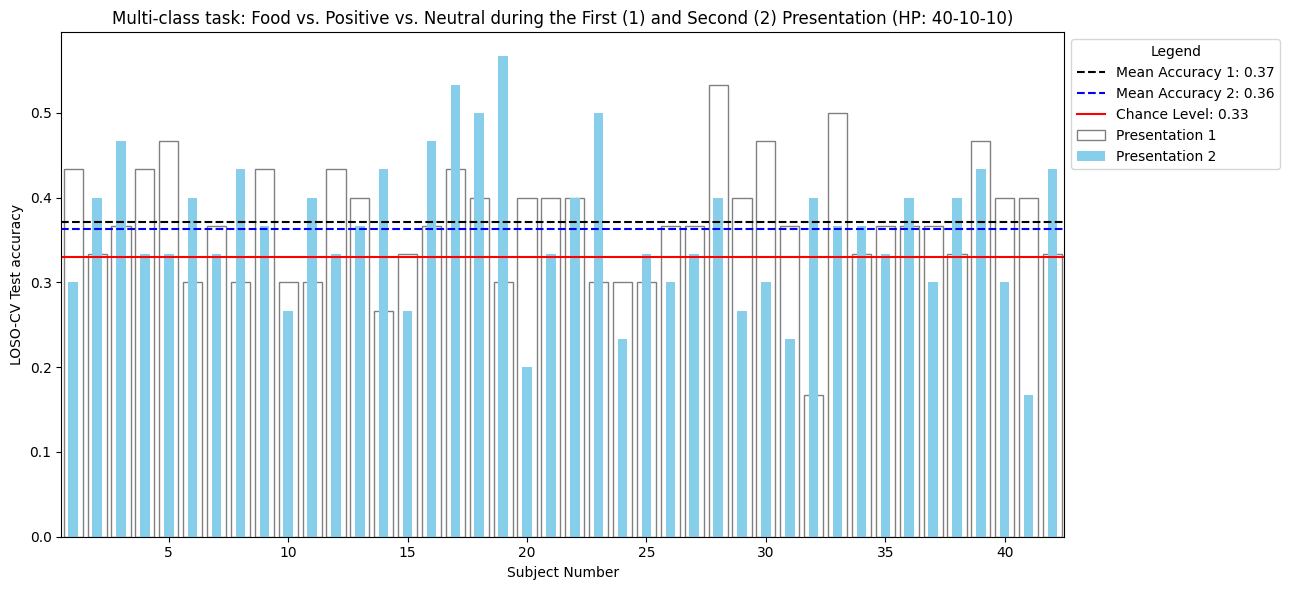

In [19]:
# Example accuracy data
accuracies1 = list_multi_accuracies[1]  # Replace with your first list
accuracies2 = list_multi_accuracies[2]  # Replace with your second list

# Calculate mean accuracies for both sets
mean_accuracy1 = np.mean(accuracies1)
mean_accuracy2 = np.mean(accuracies2)

# Set up the figure and axis with increased figsize
fig, ax = plt.subplots(figsize=(13, 6))  # Increased size (width=10, height=6)

# X positions for the bars
x = np.arange(1, len(accuracies1) + 1)  # x positions for the bars

# Create the first bar graph (no fill color)
ax.bar(x, accuracies1, edgecolor='gray', width=0.8, align='center', linewidth=1, color='white', label='Presentation 1')

# Create the second bar graph with dashed lines (hatch pattern)
ax.bar(x, accuracies2, edgecolor='none', width=0.4, align='center', linewidth=0.5, facecolor='skyblue', label='Presentation 2')

# Add the mean accuracies as horizontal lines
ax.axhline(y=mean_accuracy1, color='black', linestyle='--', label=f'Mean Accuracy 1: {mean_accuracy1:.2f}')
ax.axhline(y=mean_accuracy2, color='blue', linestyle='--', label=f'Mean Accuracy 2: {mean_accuracy2:.2f}')

# Add a horizontal line for chance level (0.33)
ax.axhline(y=0.33, color='red', linestyle='-', label='Chance Level: 0.33')

# Set labels and title
ax.set_xlabel('Subject Number')
ax.set_ylabel('LOSO-CV Test accuracy')
ax.set_title('Multi-class task: Food vs. Positive vs. Neutral during the First (1) and Second (2) Presentation (HP: 40-10-10)')

# Set x-axis to start at 1
ax.set_xlim(0.5, len(accuracies1) + 0.5)

# Place the legend outside the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Legend")

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

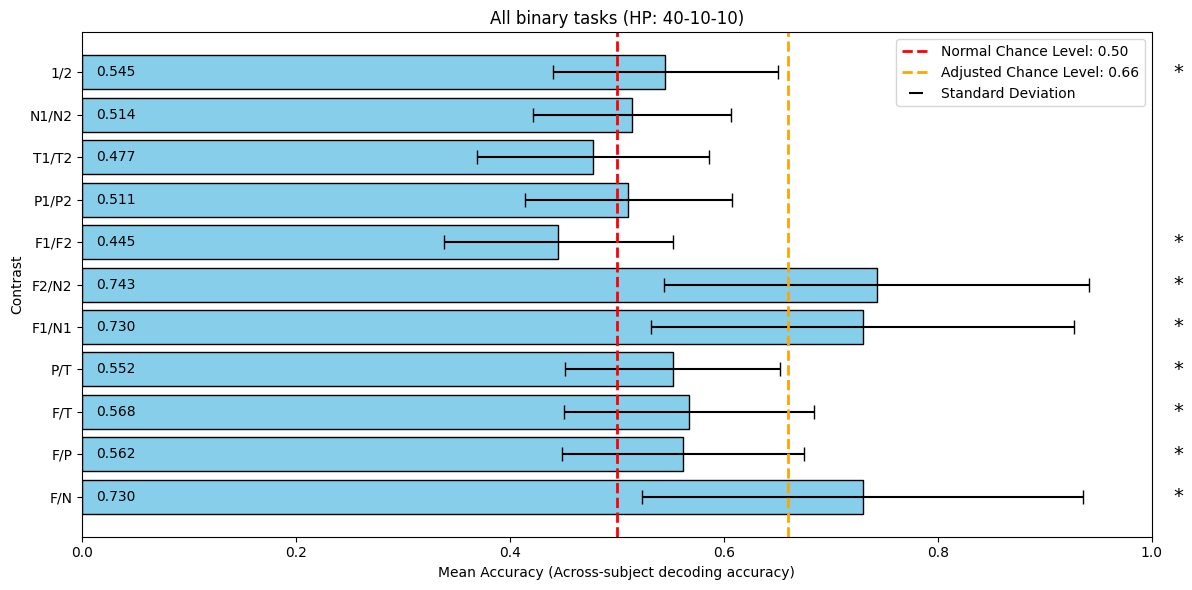

In [39]:
# Calculate mean accuracies for each list
mean_accuracies = [np.mean(accuracies) for accuracies in list_binary_accuracies]

# Calculate standard deviations for error bars
std_devs = [np.std(accuracies) for accuracies in list_binary_accuracies]

# Chance levels
chance_1 = 0.5
chance_2 = 0.66

# Set up the figure
fig, ax = plt.subplots(figsize=(12, 6))

# Bar plot for the mean accuracies with error bars
bars = ax.barh(range(1, len(mean_accuracies) + 1), mean_accuracies, xerr=std_devs, capsize=5, color='skyblue', edgecolor='black')

# Add chance level lines
ax.axvline(x=chance_1, color='red', linestyle='--', linewidth=2, label=f'Normal Chance Level: 0.50')
ax.axvline(x=chance_2, color='orange', linestyle='--', linewidth=2, label=f'Adjusted Chance Level: 0.66')

# Add annotations for the means
for bar in bars:
    width = bar.get_width()
    ax.text(0.05, bar.get_y() + bar.get_height() / 2, f'{width:.3f}', va='center', ha='right', color='black', fontsize=10)

# Manual asterisk placement (Define which datasets should have which symbols)
asterisks = {
    0: '*',  
    1: '*',   
    2: '*',  
    3: '*',   
    4: '*',
    5: '*',
    6: '*',
    10: '*', 
}

# Add the asterisks manually to the bars
for idx, symbol in asterisks.items():
    ax.text(1.02, idx + 1, symbol, va='center', ha='left', color='black', fontsize=14)


# Add a dummy plot for the standard deviation (error bars) to create a legend entry
ax.errorbar([], [], xerr=1, fmt='o', color='black', label='Standard Deviation', markersize=0)  # dummy error bar

# Set labels and title
ax.set_xlabel('Mean Accuracy (Across-subject decoding accuracy)')
ax.set_ylabel('Contrast')
ax.set_title('All binary tasks (HP: 40-10-10)')

# Customize x-axis
ax.set_xlim(0, 1)

# Set custom y-tick labels manually
y_labels = ["F/N", "F/P", "F/T", "P/T", "F1/N1", "F2/N2", "F1/F2", "P1/P2", "T1/T2", "N1/N2", "1/2"]  # Custom labels
ax.set_yticks(range(1, len(mean_accuracies) + 1))  # Set y-ticks positions
ax.set_yticklabels(y_labels)  # Assign the custom labels

# Add legend
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [80]:
directory = 'Z:\Don\ML_Project\Results'

list_binary_poststim = np.load(f'{directory}\list_binary_accuracies_40_10_10.npy')
list_binary_M100 = np.load(f'{directory}\list_binary_accuracies_M100_2_10_13.npy')
list_binary_M200 = np.load(f'{directory}\list_binary_accuracies_M200_2_10_10.npy')
list_binary_M300 = np.load(f'{directory}\list_binary_accuracies_M300_4_10_10.npy')
list_binary_LPP = np.load(f'{directory}\list_binary_accuracies_LPP_20_10_11.npy')

list_mult_poststim = np.load(f'{directory}\list_binary_accuracies_40_10_10.npy')
list_mult_M100 = np.load(f'{directory}\list_multi_accuracies_M100_2_10_13.npy')
list_mult_M200 = np.load(f'{directory}\list_multi_accuracies_M200_2_10_10.npy')
list_mult_M300 = np.load(f'{directory}\list_multi_accuracies_M300_4_10_10.npy')
list_mult_LPP =  np.load(f'{directory}\list_multi_accuracies_LPP_20_10_11.npy')

list_binary_acc = [list_binary_poststim, list_binary_M100, list_binary_M200, list_binary_M300, list_binary_LPP]
list_mult_acc = [list_mult_poststim[3], list_mult_M100[3], list_mult_M200[3], list_mult_M300[3], list_mult_LPP[3]]

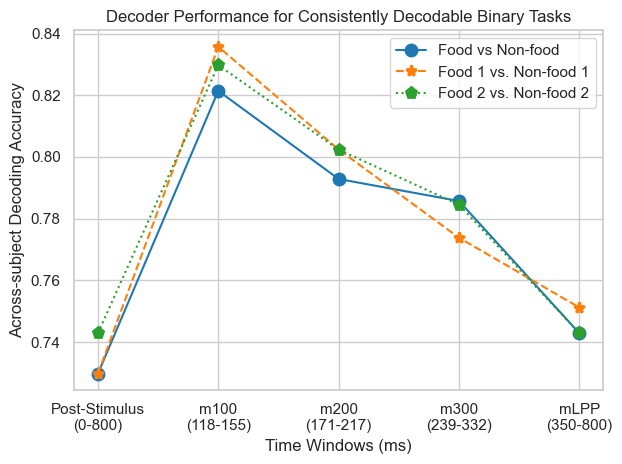

In [146]:
import matplotlib.pyplot as plt
import numpy as np

mean_food_vs_nonfood = []
mean_food_1_vs_nonfood_1 = []
mean_food_2_vs_nonfood_2 = []

for contrasts in list_binary_acc:
    food_vs_nonfood = contrasts[0]
    food_1_vs_nonfood_1 = contrasts[4]
    food_2_vs_nonfood_2 = contrasts[5]

    mean_food_vs_nonfood.append(np.mean(food_vs_nonfood))
    mean_food_1_vs_nonfood_1.append(np.mean(food_1_vs_nonfood_1))
    mean_food_2_vs_nonfood_2.append(np.mean(food_2_vs_nonfood_2))

# Define custom x-axis labels with line breaks using \n
x_labels = [
    'Post-Stimulus\n(0-800)',
    'm100\n(118-155)',
    'm200\n(171-217)',
    'm300\n(239-332)',
    'mLPP\n(350-800)'
]

# Plot the means
plt.plot(x_labels, mean_food_vs_nonfood, label='Food vs Non-food', marker='o', markersize=8, linestyle='-', color='#1f77b4', markeredgewidth=2)
plt.plot(x_labels, mean_food_1_vs_nonfood_1, label='Food 1 vs. Non-food 1', marker='*', markersize=8, linestyle='--', color='#ff7f0e', markeredgewidth=2)
plt.plot(x_labels, mean_food_2_vs_nonfood_2, label='Food 2 vs. Non-food 2', marker='p', markersize=8, linestyle=':', color='#2ca02c', markeredgewidth=2)

plt.xlabel('Time Windows (ms)')
plt.ylabel('Across-subject Decoding Accuracy')
plt.title('Decoder Performance for Consistently Decodable Binary Tasks')
plt.legend()
plt.tight_layout()  # Adjust layout to fit the labels
plt.show()

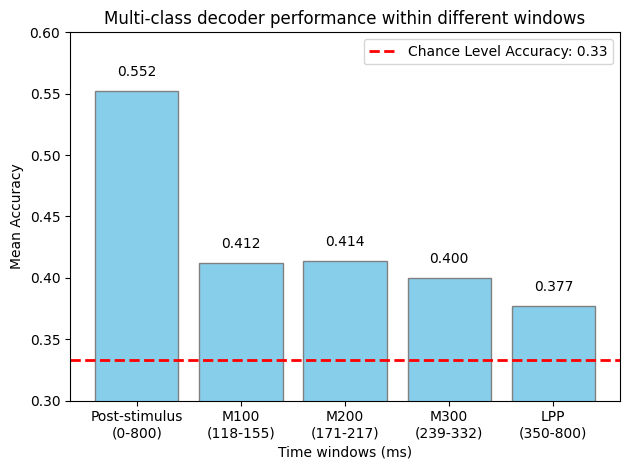

In [ ]:
# Assume list_mult_acc is defined as you mentioned
list_mult_acc = [list_mult_poststim[3], list_mult_M100[3], list_mult_M200[3], list_mult_M300[3], list_mult_LPP[3]]

# Calculate the mean accuracy for each list in list_mult_acc
mean_accuracies = [np.mean(acc) for acc in list_mult_acc]

# Define x-axis labels (time windows)
x_labels = [
    'Post-stimulus\n(0-800)',
    'M100\n(118-155)',
    'M200\n(171-217)',
    'M300\n(239-332)',
    'LPP\n(350-800)'
]

# Set positions for the bars
index = np.arange(len(x_labels))

# Create the bar plot
bars = plt.bar(index, mean_accuracies, color='skyblue', edgecolor='gray')

# Set the x-axis labels
plt.xticks(index, x_labels)

# Adjust the y-axis limits
plt.ylim(0.3, 0.6)  # This sets the y-axis range from 0.3 to 0.6

# Add a red horizontal dashed line at y = 0.333
plt.axhline(y=0.333, color='red', linestyle='--', linewidth=2, label='Chance Level Accuracy: 0.33')

# Add the values of each bar on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# Add labels and title
plt.xlabel('Time windows (ms)')
plt.ylabel('Mean Accuracy')
plt.title('Multi-class decoder performance within different windows')

# Add the legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

Yarden Comments
- Show mean accuracy with SEM or std; show Wilcoxon on subtracted data (across subjects) and show it is different from zero (DONE!)
- Source space decoding (could be)
- Mention duration length taken from MEG (it was literally mentioned, bruh)
- Why PCA? Try without (lol, no.)

- Show basic stats of raw data

In [ ]:
list_binary_accuracies = np.load("Z:/Don/ML_Project/Results/list_binary_accuracies_40_10_10.npy")
list_binary_accuracies.shape

list_multi_accuracies = np.load("Z:/Don/ML_Project/Results/list_multi_accuracies_40_10_10.npy")
list_multi_accuracies.shape

list_binary_multi_40_10_10 = np.vstack((list_binary_accuracies, list_multi_accuracies))
list_binary_multi_40_10_10.shape

(7, 42)

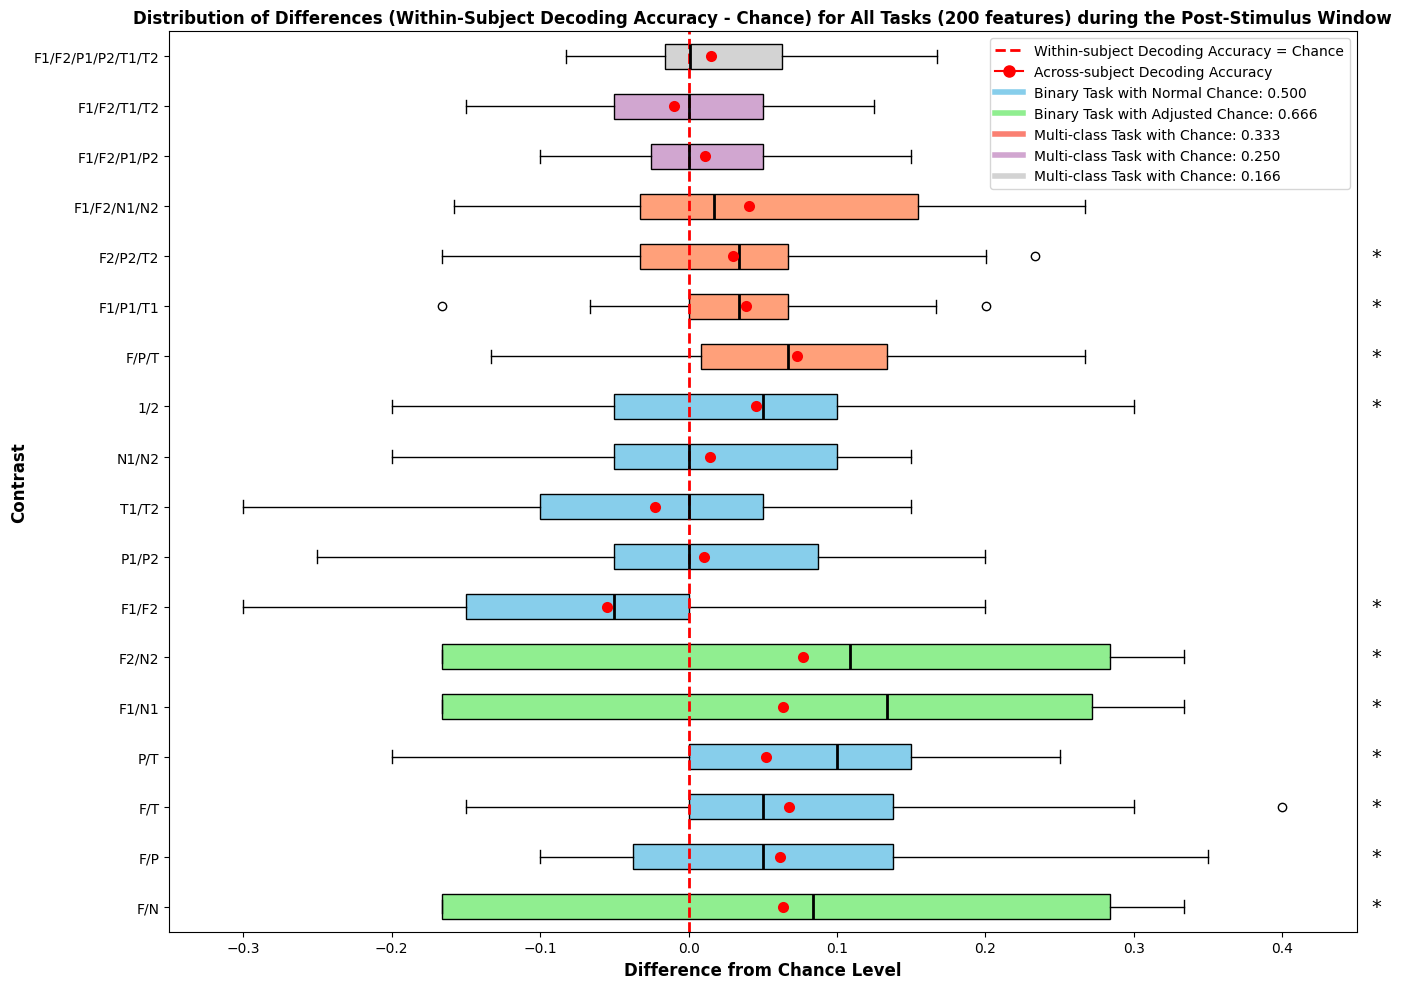

Group 1: Wilcoxon test p-value = 0.0149
Group 2: Wilcoxon test p-value = 0.0007
Group 3: Wilcoxon test p-value = 0.0005
Group 4: Wilcoxon test p-value = 0.0016
Group 5: Wilcoxon test p-value = 0.0172
Group 6: Wilcoxon test p-value = 0.0061
Group 7: Wilcoxon test p-value = 0.0040
Group 8: Wilcoxon test p-value = 0.4240
Group 9: Wilcoxon test p-value = 0.3889
Group 10: Wilcoxon test p-value = 0.1945
Group 11: Wilcoxon test p-value = 0.0059
Group 12: Wilcoxon test p-value = 0.0000
Group 13: Wilcoxon test p-value = 0.0001
Group 14: Wilcoxon test p-value = 0.0094
Group 15: Wilcoxon test p-value = 0.0502
Group 16: Wilcoxon test p-value = 0.1987
Group 17: Wilcoxon test p-value = 0.4319
Group 18: Wilcoxon test p-value = 0.0997


In [ ]:
# Multiple chance levels corresponding to each list of accuracies
chance_levels = [0.666, 0.500, 0.500, 
                 0.500, 0.666, 0.666,
                 0.500, 0.500, 0.500,
                 0.500, 0.500, 0.333,
                 0.333, 0.333, 0.333,
                 0.250, 0.250, 0.166]

# Prepare to collect results for plotting
all_differences = []
all_p_values = []

# Loop through each list of accuracies and corresponding chance level
for idx, (accuracies, chance_level) in enumerate(zip(list_binary_multi_40_10_10, chance_levels)):
    # Step 1: Subtract the chance level from each accuracy
    differences = np.array(accuracies) - chance_level
    all_differences.append(differences)

    # Step 2: Perform the Wilcoxon signed-rank test
    stat, p_value = wilcoxon(differences)
    all_p_values.append(p_value)

# Set up the figure for plotting
fig, ax = plt.subplots(figsize=(14, 10))

# Step 3a: Create a Boxplot of the differences for each list
boxes = ax.boxplot(all_differences, vert=False, patch_artist=True, 
                   boxprops=dict(facecolor='skyblue', color='black'),
                   medianprops=dict(color='black', linewidth=2), showmeans=True,
                   meanprops=dict(marker='o', markerfacecolor='red', markersize=8, markeredgecolor='none'))

# Apply custom colors to the specified groups
for i, box in enumerate(boxes['boxes']):
    if i == 0 or i == 4 or i == 5:
        box.set_facecolor('lightgreen')
    elif i == 11 or i == 12 or i == 13 or i == 14:
        box.set_facecolor('lightsalmon')
    elif i == 15 or i == 16:
        box.set_facecolor('#D1A6D0')
    elif i == 17:
        box.set_facecolor('lightgray')

# Manual asterisk placement (Define which datasets should have which symbols)
asterisks = {
    0: '*',  
    1: '*',   
    2: '*',  
    3: '*',   
    4: '*',
    5: '*',
    6: '*',
    10: '*',
    11: "*",
    12: "*",
    13: "*"
}

# Add the asterisks manually to the bars
for idx, symbol in asterisks.items():
    ax.text(0.46, idx + 1, symbol, va='center', ha='left', color='black', fontsize=14)

# Add only one chance level line (reference line)
ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Within-subject Decoding Accuracy = Chance')

# Create a custom legend for the mean marker
mean_marker = Line2D([0], [0], color='red', marker='o', markersize=8, label='Across-subject decoding accuracy')

# Create a custom legend for the blue boxplots
blue_box_legend = Line2D([0], [0], color='skyblue', lw=4, label='Binary Task with normal chance levels (0.50)')

# Create a custom legend for the green boxplots (highlighted tasks)
green_box_legend = Line2D([0], [0], color='lightgreen', lw=4, label='Binary Task with adjusted chance levels (0.66)')

# Create a custom legend for the green boxplots (highlighted tasks)
salmon_box_legend = Line2D([0], [0], color='salmon', lw=4, label='Multi-class Tasks with Chance: 0.333')

# Create a custom legend for the green boxplots (highlighted tasks)
lavender_box_legend = Line2D([0], [0], color='#D1A6D0', lw=4, label='Multi-class Tasks with Chance: 0.250')

# Create a custom legend for the green boxplots (highlighted tasks)
lightgray_box_legend = Line2D([0], [0], color='lightgray', lw=4, label='Multi-class Tasks with Chance: 0.166')

# Add titles and labels for both plots
ax.set_title('Distribution of Differences (Within-Subject Decoding Accuracy - Chance) for All Tasks (200 features) during the Post-Stimulus Window', fontdict={'fontsize':12, 'fontweight':'bold'})
ax.set_xlabel('Difference from Chance Level', fontdict={'fontsize':12, 'fontweight':'bold'})
ax.set_ylabel('Contrast', fontdict={'fontsize':12, 'fontweight':'bold'})

# Add legend for the chance level line
# This will ensure that the legend only shows once for the chance level line
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles + [mean_marker, blue_box_legend, green_box_legend, salmon_box_legend, lavender_box_legend, lightgray_box_legend], 
          labels + ['Across-subject Decoding Accuracy', 'Binary Task with Normal Chance: 0.500', 
                    'Binary Task with Adjusted Chance: 0.666', "Multi-class Task with Chance: 0.333",
                    "Multi-class Task with Chance: 0.250", "Multi-class Task with Chance: 0.166"], 
          loc='upper right', bbox_to_anchor=(1, 1))

# Set x and y limits for better visualization
ax.set_xlim(-0.35, 0.45)

# Set custom labels for the boxplot
y_labels = ["F/N", "F/P", "F/T", "P/T", "F1/N1", "F2/N2", 
            "F1/F2", "P1/P2", "T1/T2", "N1/N2", "1/2", "F/P/T", 
            "F1/P1/T1", "F2/P2/T2", "F1/F2/N1/N2", "F1/F2/P1/P2", "F1/F2/T1/T2", "F1/F2/P1/P2/T1/T2"]  # Custom labels
ax.set_yticklabels(y_labels)

# Display the plot
plt.tight_layout()
plt.show()

# # Output Wilcoxon test results for each group
# for i, p_value in enumerate(all_p_values):
#     print(f"Group {i + 1}: Wilcoxon test p-value = {p_value:.4f}")

Plot Descriptive Summary Statistics across subjects

Average over trials and channels

In [ ]:
# Set directories
data_dir = 'z:\Don\ML_Project\Poststimulus_files\evoked_cond_concat_binary_and_multiclass'  # Directory containing all subject directories
subjects = [d for d in os.listdir(data_dir) if d.startswith('sub_')]
conditions = ['food', 'positive', 'neutral', 'nonfood', 
              'food_1', 'food_2', 'positive_1', 'positive_2', 
              'neutral_1', 'neutral_2', 'nonfood_1', 'nonfood_2',
              'pres_1', 'pres_2']  # List all your conditions

# Initialize a dictionary to hold the summary statistics
summary_stats = {condition: {'rms': [], 'sem': []} for condition in conditions}

# Define the time truncation point (in ms) and sampling rate
time_truncate_ms = 800  # Time to truncate (in ms)
sampling_rate_hz = 1000  # Assume a 1 kHz sampling rate (1 ms per time point)
time_truncate_points = int(time_truncate_ms * sampling_rate_hz / 1000)  # Convert to time points

# Loop through each subject and condition to compute summary statistics
for subject in subjects:
    subject_dir = os.path.join(data_dir, subject)
    
    for condition in conditions:
        condition_path = os.path.join(subject_dir, condition + '.npy')  # Assuming data is stored in .npy format
        if os.path.exists(condition_path):
            data = np.load(condition_path)  # Shape: (n_trials, n_channels, n_time)

            # Average across trials (axis 0)
            data_avg_trials = np.mean(data, axis=0)  # Shape: (n_channels, n_time)
            
            # Compute RMS across channels (axis 0 of the averaged data)
            rms_data = np.sqrt(np.mean(np.square(data_avg_trials), axis=0))  # RMS across channels, keeping time
            
            # Compute SEM across trials (axis 0)
            sem_data = rms_data / np.sqrt(data.shape[0]*data.shape[1])  # SEM from RMS, keeping time

            # # Average the SEM across channels (axis 0)
            # sem_data = np.mean(sem_data, axis=0)

            # Truncate the data up to the desired time point
            rms_data_truncated = rms_data[:time_truncate_points]
            sem_data_truncated = sem_data[:time_truncate_points]

            # Append results to the summary_stats dictionary
            if condition not in summary_stats:
                summary_stats[condition] = {'rms': [], 'sem': []}
            summary_stats[condition]['rms'].append(rms_data_truncated)
            summary_stats[condition]['sem'].append(sem_data_truncated)

# Now, let's calculate the overall RMS and SEM across all subjects for each condition
final_rms = {}
final_sem = {}

for condition in conditions:
    final_rms[condition] = np.mean(summary_stats[condition]['rms'], axis=0)
    final_sem[condition] = np.mean(summary_stats[condition]['sem'], axis=0)

final_rms_savepath = "Z:\Don\ML_Project\Summary_statistics_plots/poststimulus_rms_new2.npy"
np.save(final_rms_savepath, final_rms, allow_pickle=True)

final_sem_savepath = "Z:\Don\ML_Project\Summary_statistics_plots/poststimulus_sem_new2.npy"
np.save(final_sem_savepath, final_sem, allow_pickle=True)

In [180]:
def plot_summary_signals(final_rms, conditions, labels, txt, title, scale):

    plt.figure(figsize=(10, 6))

    # Plotting the summary statistics
    time_points = np.arange(final_rms[conditions[0]].shape[0])  # Assuming time dimension is the same across conditions

    for condition, label in zip(conditions, labels):
        plt.plot(time_points, final_rms[condition], label=label)
        # plt.fill_between(time_points, final_rms[condition] - final_sem[condition], 
        #                 final_rms[condition] + final_sem[condition], alpha=0.3)
        
    # Highlight regions with different start and end times
    highlight_start_times = [0.118, 0.171, 0.239, 0.350]  # Start times for M100, M200, M300, LPP
    highlight_end_times = [0.155, 0.217, 0.332, 0.799]  # End times for M100, M200, M300, LPP
    highlight_labels = ['m100', 'm200', 'm300', 'mLPP']  # Labels for the regions

    # Loop through the highlight regions and add them to the plot
    for start_time, end_time, label in zip(highlight_start_times, highlight_end_times, highlight_labels):
        # Convert start and end times (in seconds) to indices
        highlight_start_idx = np.searchsorted(time_points, start_time * 1000)  # Convert to ms
        highlight_end_idx = np.searchsorted(time_points, end_time * 1000)  # Convert to ms
        
        # Highlight the region
        plt.axvspan(time_points[highlight_start_idx], time_points[highlight_end_idx], color='wheat', alpha=0.3)

        # Calculate the x and y positions for the text inside the highlighted region
        text_x_position = (time_points[highlight_start_idx] + time_points[highlight_end_idx]) / 2
        text_y_position = plt.gca().get_ylim()[1] * scale  # Adjust text position relative to the plot's y-limits
        
        # Add text for the highlighted region
        plt.text(text_x_position, text_y_position, label, color='black', ha='center', va='center', fontsize=12)

    plt.text(-40, plt.gca().get_ylim()[1]*1.01, txt, color='black', ha='center', va='center', fontsize=14, fontweight='bold')
    plt.xlabel('Time relative to stimulus onset (ms)')
    plt.ylabel('RMS Amplitude (T)')
    plt.title(f'Descriptive Summary of Evoked Responses by {title} across Trials and Channels')
    plt.legend(loc='upper right')
    plt.xlim(0, 800)  # Truncate the x-axis to 800 ms
    plt.show()

In [ ]:
final_rms = np.load("Z:\Don\ML_Project\Summary_statistics_plots/poststimulus_rms_new2.npy", allow_pickle=True)
final_rms = final_rms.item()
final_sem = np.load("Z:\Don\ML_Project\Summary_statistics_plots/poststimulus_sem_new2.npy", allow_pickle=True)
final_sem = final_sem.item()

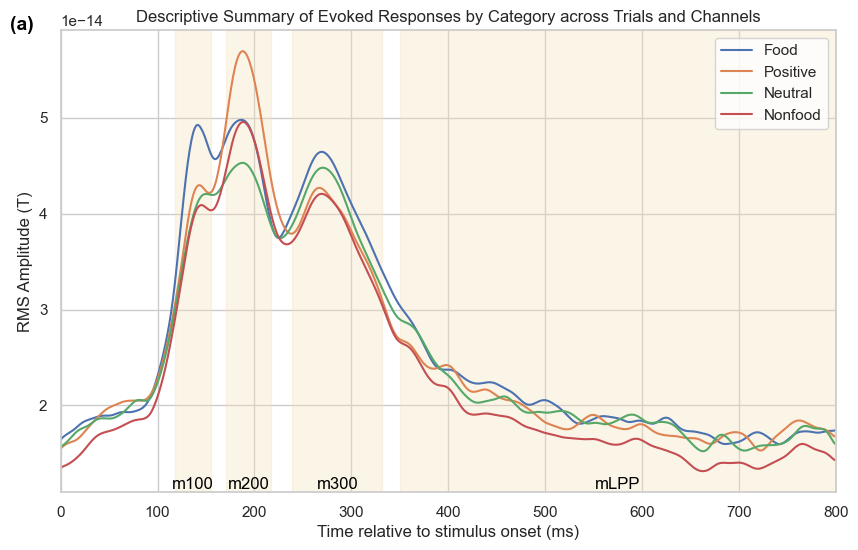

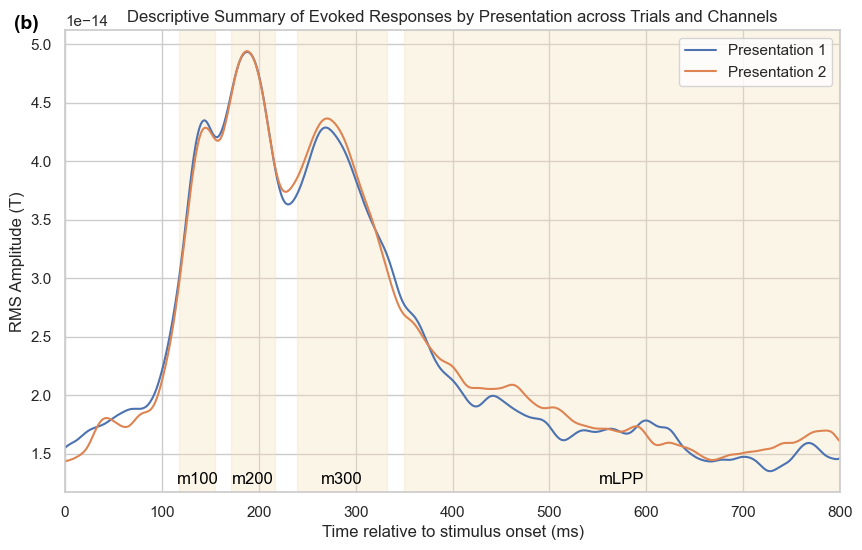

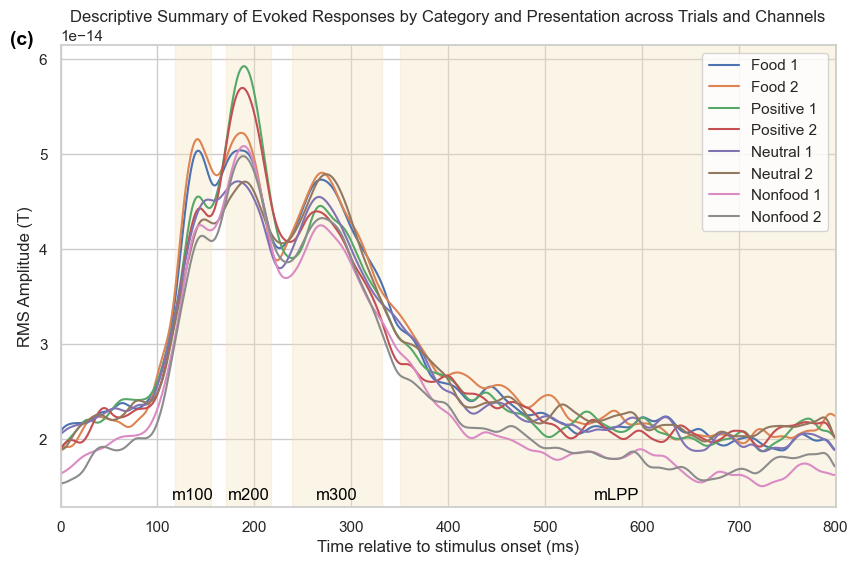

In [181]:
conditions = ["food", "positive", "neutral", "nonfood"]
labels = ["Food", "Positive", "Neutral", "Nonfood"]
plot_summary_signals(final_rms, conditions, labels, "(a)", "Category", 0.2)

conditions = ["pres_1", "pres_2"]
labels = ['Presentation 1', "Presentation 2"]
plot_summary_signals(final_rms, conditions, labels, "(b)", "Presentation", 0.25)

conditions = ["food_1", "food_2", "positive_1", "positive_2", "neutral_1", "neutral_2", "nonfood_1", "nonfood_2"]
labels = ['Food 1', "Food 2", "Positive 1", "Positive 2", "Neutral 1", "Neutral 2", "Nonfood 1", "Nonfood 2"]
plot_summary_signals(final_rms, conditions, labels, "(c)", "Category and Presentation", 0.23)

Average over trials, channels, time (boxplots)

In [ ]:
def plot_summary_boxplots(final_rms, start_time_ms, end_time_ms, txt, title, color):

        conditions = ['food', 'positive', 'neutral', 'nonfood', 
                'food_1', 'food_2', 'positive_1', 'positive_2', 
                'neutral_1', 'neutral_2', 'nonfood_1', 'nonfood_2',
                'pres_1', 'pres_2']  # List all your conditions

        labels = ["Food", "Positive", "Neutral", 
                "Nonfood", "Food 1", "Food 2", 
                "Positive 1", "Positive 2", "Neutral 1", 
                "Neutral 2", "Nonfood 1", "Nonfood 2", 
                "Presentation 1", "Presentation 2"]

        # Convert the time range from ms to index positions in the time_points array
        start_idx = np.searchsorted(np.arange(0,800), start_time_ms)
        end_idx = np.searchsorted(np.arange(0,800), end_time_ms)

        # Create boxplots for RMS values across conditions (no need to average across time points)
        plt.figure(figsize=(10, 6))

        # Each condition has an array of RMS values for each time point (shape (800,))
        data_to_plot = [final_rms[condition][start_idx:end_idx] for condition in conditions]

        # Plot RMS boxplots using seaborn, without fill (no color)
        sns.boxplot(data=data_to_plot, palette="Set2", 
                boxprops=dict(facecolor=color, edgecolor='black'))  # No fill, black edge color

        # Add title, labels, and configure plot
        plt.text(-1.1, plt.gca().get_ylim()[1]*1.02, txt, color='black', ha='center', va='center', fontsize=14, fontweight='bold')
        plt.title(f'Descriptive Summary of Evoked Responses across Trials, Channels, and Time during the {title}')
        plt.xlabel('Condition')
        plt.xticks(ticks=range(len(conditions)), labels=labels, rotation=45)
        plt.ylabel('RMS Amplitude (T)')

        plt.tight_layout()  # Ensure labels fit
        plt.grid(False)
        plt.show()

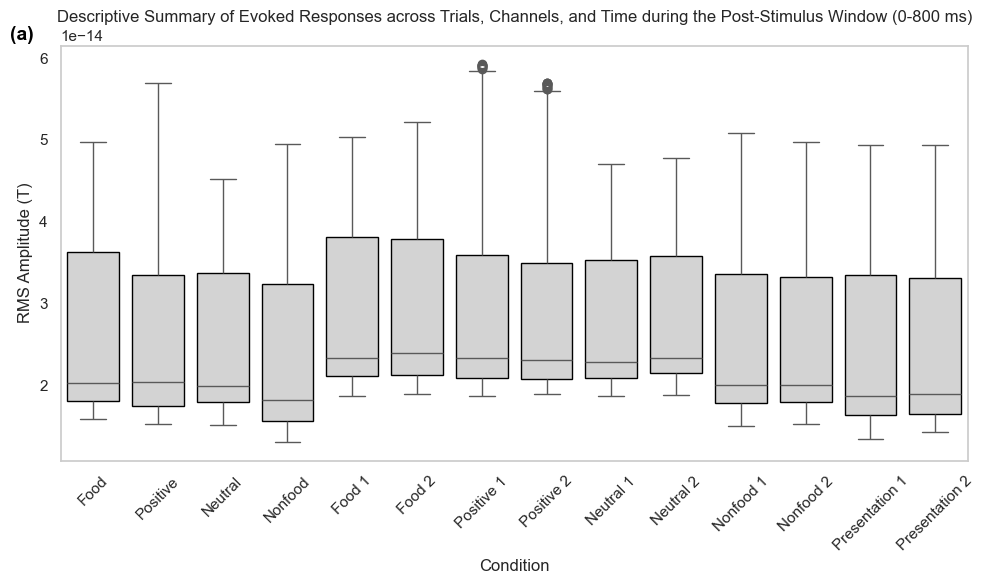

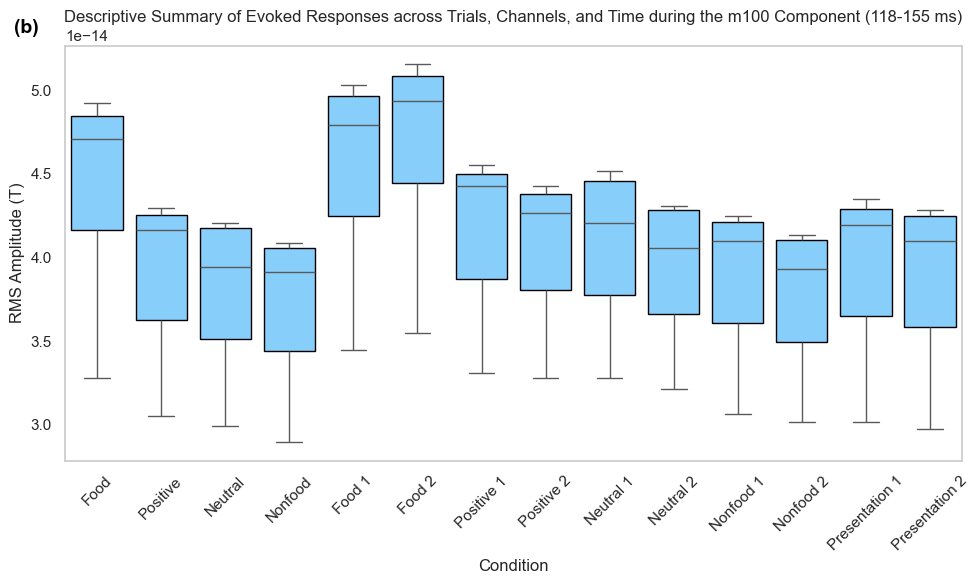

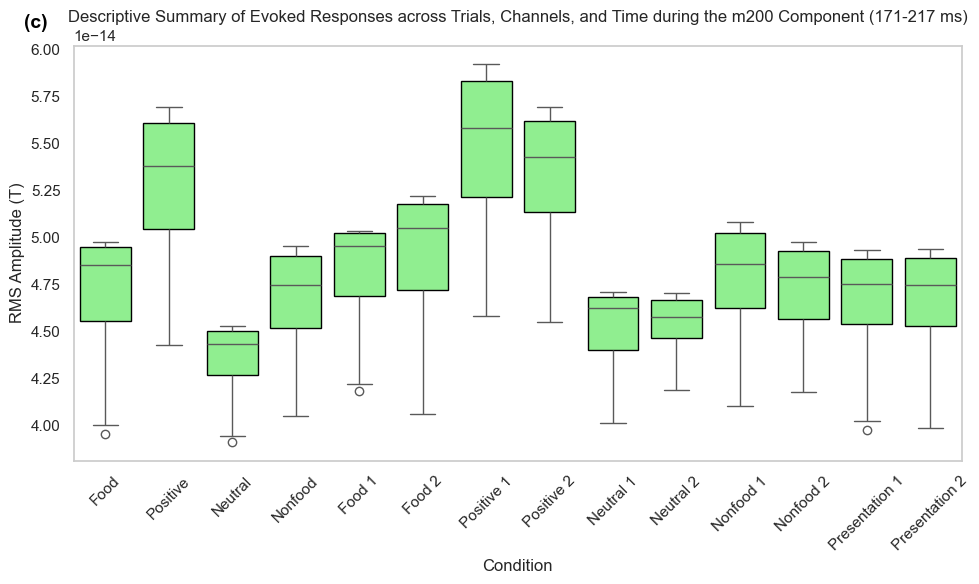

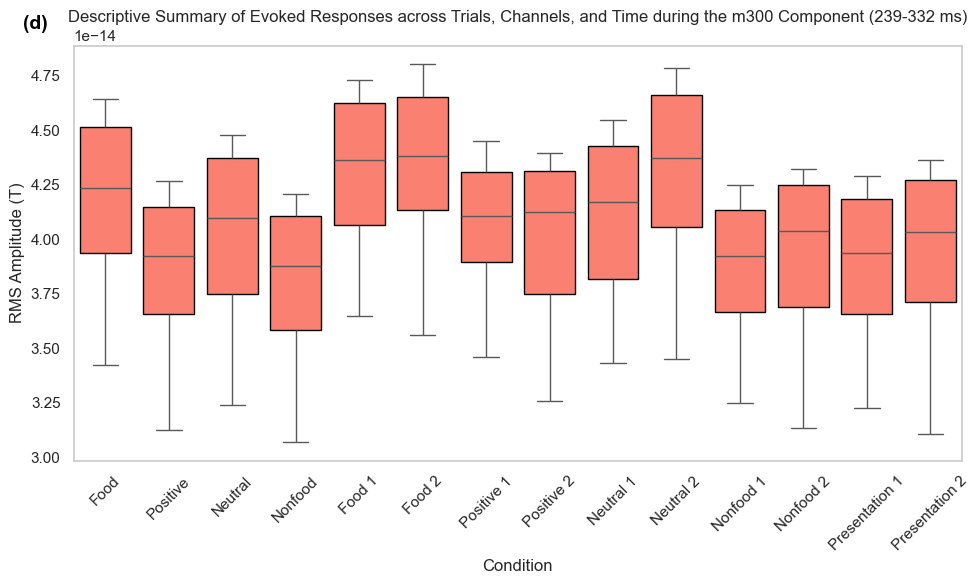

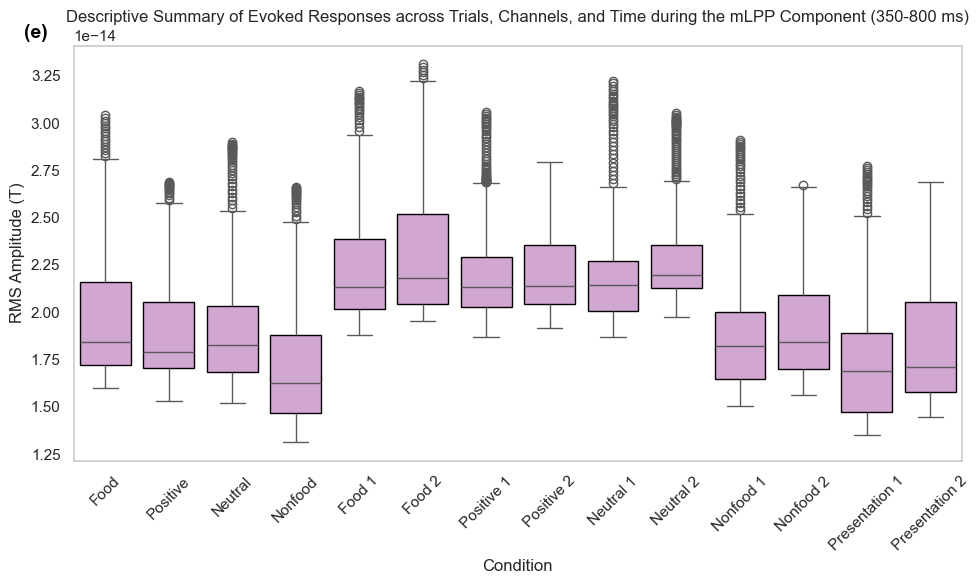

In [189]:
final_rms = np.load("Z:\Don\ML_Project\Summary_statistics_plots/poststimulus_rms_new.npy", allow_pickle=True)
final_rms = final_rms.item()

plot_summary_boxplots(final_rms, 0, 800, "(a)", "Post-Stimulus Window (0-800 ms)", "lightgray")
plot_summary_boxplots(final_rms, 118, 155, "(b)", "m100 Component (118-155 ms)", "lightskyblue")
plot_summary_boxplots(final_rms, 171, 217, "(c)", "m200 Component (171-217 ms)", "lightgreen")
plot_summary_boxplots(final_rms, 239, 332, "(d)", "m300 Component (239-332 ms)", "salmon")
plot_summary_boxplots(final_rms, 350, 800, "(e)", "mLPP Component (350-800 ms)", "#D1A6D0")

Trying permutation test for ensemble classifier

In [46]:
def decode_and_permute(cond_list:list, savefile:str, n_permutations:int=10):
    """
    A two-part function that performs the decoding and a permutation test for it.

    Parameters:
    cond_list (list) - List of binary or multi-class classification tests to perform decoding and permutation on.
    n_permutations - The number of permutations for permutation testing. Default is 10.
    savefile (str) - The directory where to save the (1) decoding and (2) permutation test results.
    Recommended savefile should show the task, window, and hyperparameters e.g., multi_M100_40_10_10

    Returns: Two ndarray (.npy) files containing the results.
    """
    
    # Define different categorization sets
    list_cond_accuracies = []

    # To store permutation test results
    permutation_test_results = {}

    # Loop through each condition set
    for conditions_set in cond_list:
        print(f"Running with categorization: {conditions_set}")

        # Load the data for the current categorization set
        subjects_data = {}
        for subject in os.listdir(base_dir):
            subject_dir = os.path.join(base_dir, subject)
            if os.path.isdir(subject_dir):
                subject_data = {}
                for condition in conditions_set:  # Use the current categorization set
                    condition_file = os.path.join(subject_dir, f'{condition}.npy')
                    if os.path.exists(condition_file):
                        subject_data[condition] = np.load(condition_file)
                subjects_data[subject] = subject_data

        # Prepare the data
        X, y, groups = reshape_data(subjects_data, conditions_set)

        # Define the base classifiers
        base_classifiers = [
            ('svm', SVC(probability=True, random_state=42)),
            ('lda', LDA()),
            ('gnb', GaussianNB())
        ]

        # Final classifier (Logistic Regression) with default parameters
        final_classifier = LogisticRegression(random_state=42)

        # Create the stacking classifier without hyperparameter optimization
        stacking_clf = StackingClassifier(
            estimators=base_classifiers,
            final_estimator=final_classifier
        )

        # Leave-One-Subject-Out Cross Validation
        logo = LeaveOneGroupOut()
        cond_accuracies = []

        for train_idx, test_idx in logo.split(X, y, groups):
            # Extract the current test subject
            test_subject = groups[test_idx][0]
            print(f"Testing on subject: {test_subject}")
            
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            # Standardize the data
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            
            # Build the stacking classifier with default base models
            stacking_clf.fit(X_train, y_train)
            
            # Test the classifier
            y_pred = stacking_clf.predict(X_test)
            cond_accuracy = balanced_accuracy_score(y_test, y_pred)
            cond_accuracies.append(cond_accuracy)
            print(f"Subject {test_subject} accuracy: {cond_accuracy:.2f}\n")

        # List the lists
        list_cond_accuracies.append(cond_accuracies)

        # Calculate the observed mean accuracy for the current condition set
        observed_accuracy = np.mean(cond_accuracies)
        print(f"Observed mean accuracy (Across-subject decoding accuracy): {observed_accuracy:.2f}")

        # Permutation test
        permuted_accuracies = []

        for perm_num in range(n_permutations):
            # Shuffle the labels (y), but keep the data (X) fixed
            y_permuted = shuffle(y, random_state=perm_num)
            
            # Perform LOSO cross-validation on the permuted labels
            permuted_accuracy = []
            for train_idx, test_idx in logo.split(X, y_permuted, groups):
                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = y_permuted[train_idx], y_permuted[test_idx]
                
                # Standardize the data
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)
                
                # Fit the classifier
                stacking_clf.fit(X_train, y_train)
                
                # Predict
                y_pred = stacking_clf.predict(X_test)
                permuted_accuracy.append(balanced_accuracy_score(y_test, y_pred))
            
            permuted_accuracies.append(np.mean(permuted_accuracy))

            # Print progress every permutation
            print(f"Performed {perm_num+1} permutations so far...")

        # Compute the p-value
        p_value = np.mean(np.array(permuted_accuracies) >= observed_accuracy)
        print(f"P-value from permutation test: {p_value:.4f}")

        # Store the results in the dictionary
        # Convert binary_conditions_set to a string (hashable type)
        condition_key = "_vs_".join(conditions_set)
        permutation_test_results[condition_key] = {
            'observed_accuracy': observed_accuracy,
            'permuted_accuracies': permuted_accuracies,
            'p_value': p_value
        }

    # Save the binary accuracies and permutation test results to file
    np.save(f"Z:/Don/ML_Project/Results/Legit_Results/list_decoding_accuracies_{savefile}.npy", list_cond_accuracies)
    np.save(f"Z:/Don/ML_Project/Results/Legit_Results/permutation_test_{savefile}.npy", permutation_test_results)

    print("Results saved successfully.")

In [10]:
# Define where input data are located
base_dir = "Z:\Don\ML_Project\Window files\M100\Preprocessed_dec_pseudo_PCA"

# Define the conditions for binary classification
binary_conditions_12 = [
    "pres_1_dec_pseudo_PCA", "pres_2_dec_pseudo_PCA",
]

binary_conditions_FN = [
    "food_dec_pseudo_PCA", "nonfood_dec_pseudo_PCA",
]

binary_conditions_FP = [
    "food_dec_pseudo_PCA", "positive_dec_pseudo_PCA",
]

binary_conditions_FT = [
    "food_dec_pseudo_PCA", "neutral_dec_pseudo_PCA",
]

binary_conditions_PT = [
    "positive_dec_pseudo_PCA", "neutral_dec_pseudo_PCA",
]

binary_conditions_FN1 = [
    "food_1_dec_pseudo_PCA", "nonfood_1_dec_pseudo_PCA",
]

binary_conditions_FN2 = [
    "food_2_dec_pseudo_PCA", "nonfood_2_dec_pseudo_PCA",
]

binary_conditions_F12 = [
    "food_1_dec_pseudo_PCA", "food_2_dec_pseudo_PCA",
]

binary_conditions_P12 = [
    "positive_1_dec_pseudo_PCA", "positive_2_dec_pseudo_PCA",
]

binary_conditions_T12 = [
    "neutral_1_dec_pseudo_PCA", "neutral_2_dec_pseudo_PCA",
]

binary_conditions_N12 = [
    "nonfood_1_dec_pseudo_PCA", "nonfood_2_dec_pseudo_PCA",
]


# Define the conditions for multi-class classification
multi_conditions_3A = [
    "food_dec_pseudo_PCA", "positive_dec_pseudo_PCA", "neutral_dec_pseudo_PCA"
]

multi_conditions_3B = [
    "food_1_dec_pseudo_PCA", "positive_1_dec_pseudo_PCA", "neutral_1_dec_pseudo_PCA"
]

multi_conditions_3C = [
    "food_2_dec_pseudo_PCA", "positive_2_dec_pseudo_PCA", "neutral_2_dec_pseudo_PCA"
]

multi_conditions_4A = [
    "food_1_dec_pseudo_PCA", "food_2_dec_pseudo_PCA",
    "nonfood_1_dec_pseudo_PCA", "nonfood_2_dec_pseudo_PCA",
]

multi_conditions_4B = [
    "food_1_dec_pseudo_PCA", "food_2_dec_pseudo_PCA",
    "positive_1_dec_pseudo_PCA", "positive_2_dec_pseudo_PCA",
]

multi_conditions_4C = [
    "food_1_dec_pseudo_PCA", "food_2_dec_pseudo_PCA",
    "neutral_1_dec_pseudo_PCA", "neutral_2_dec_pseudo_PCA",
]

multi_conditions_6 = [
    "food_1_dec_pseudo_PCA", "food_2_dec_pseudo_PCA",
    "positive_1_dec_pseudo_PCA", "positive_2_dec_pseudo_PCA",
    "neutral_1_dec_pseudo_PCA", "neutral_2_dec_pseudo_PCA"
]

In [ ]:
# binary_conditions = [binary_conditions_FN, binary_conditions_FP, binary_conditions_FT,
#                     binary_conditions_PT, binary_conditions_FN1, binary_conditions_FN2,
#                     binary_conditions_F12, binary_conditions_P12, binary_conditions_T12,
#                     binary_conditions_N12, binary_conditions_12]

binary_conditions = [binary_conditions_FN, binary_conditions_12]

# 3 hours per set (e.g multi_M100_40_10_10)
decode_and_permute(cond_list=binary_conditions, n_permutations=10, savefile="binary_M100_40_10_10")

In [ ]:
permutation_test_results = np.load("Z:/Don/ML_Project/Results/Legit_Results/permutation_test_binary_M100_40_10_10.npy", allow_pickle=True)
permutation_test_results.item()

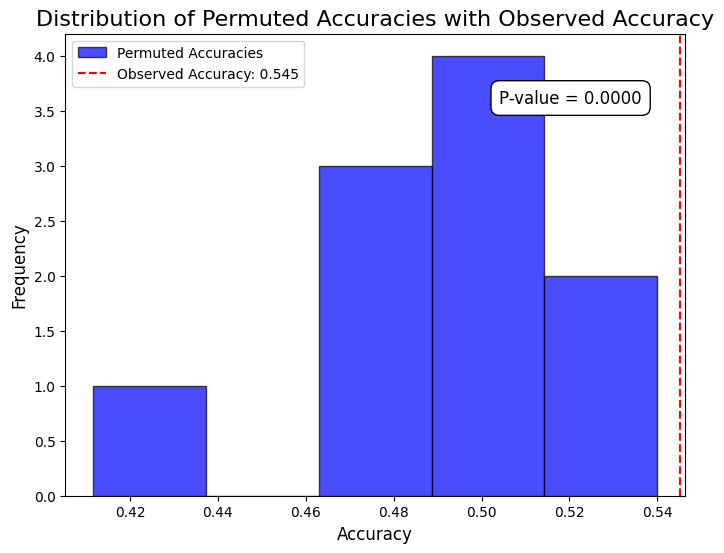

In [41]:
# Extract the permuted accuracies, observed accuracy, and p-value
permuted_accuracies = permutation_test_results.item()['pres_1_dec_pseudo_PCA_vs_pres_2_dec_pseudo_PCA']['permuted_accuracies']
observed_accuracy = permutation_test_results.item()['pres_1_dec_pseudo_PCA_vs_pres_2_dec_pseudo_PCA']['observed_accuracy']
p_value = permutation_test_results.item()['pres_1_dec_pseudo_PCA_vs_pres_2_dec_pseudo_PCA']['p_value']

# Plotting the histogram
plt.figure(figsize=(8, 6))

# Plot the histogram for permuted accuracies
plt.hist(permuted_accuracies, bins=5, color='b', alpha=0.7, label='Permuted Accuracies', edgecolor='black')

# Plot the observed accuracy as a vertical line
plt.axvline(x=observed_accuracy, color='r', linestyle='--', label=f'Observed Accuracy: {observed_accuracy:.3f}')

# Add title and labels
plt.title('Distribution of Permuted Accuracies with Observed Accuracy', fontsize=16)
plt.xlabel('Accuracy', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Add p-value annotation
plt.annotate(f'P-value = {p_value:.4f}', xy=(0.7, 0.85), xycoords='axes fraction', fontsize=12, 
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Add legend
plt.legend()

# Show the plot
plt.show()

<h3> Part 6: Additional analyses </h3>

- Temporal generalization
- Representational Similarity Analysis (RSA)
- Sensor weight projection 

<h5> 6.2: Representational Similarity Analysis (RSA) </h5>

In [ ]:
# Locate directory of the epoched (.fif) files
directory = "Z:/Don/ML_Project/Evoked_fif/sub*"

# Define file names for each condition
cond_list = ['food_short_1.npy', 'food_medium_1.npy', 'food_long_1.npy',
             'food_short_2.npy', 'food_medium_2.npy', 'food_long_2.npy',
             'positive_short_1.npy', 'positive_medium_1.npy', 'positive_long_1.npy',
             'positive_short_2.npy', 'positive_medium_2.npy', 'positive_long_2.npy',
             'neutral_short_1.npy', 'neutral_medium_1.npy', 'neutral_long_1.npy',
             'neutral_short_2.npy', 'neutral_medium_2.npy', 'neutral_long_2.npy']

# Set directory where the numpy arrays (.npy) are to be saved
directory_save = "Z:/Don/ML_Project/RSA files/conds/sub*"

# Get and sort the list of files
subject_files = sorted(glob.glob(directory))
save_folders = sorted(glob.glob(directory_save))

# Ensure the lengths match before iterating
assert len(subject_files) == len(save_folders), "Number of files and saving directories do not match."

# Perform for each subject
for file, saving_folder in zip(subject_files, save_folders):

    # Create instance of Epochs class
    epochs = mne.read_epochs(file)

    # Crop only the time of interest (e.g., 0.118 to 0.155s for M100)
    epochs_toi = epochs.crop(tmin=0.118, tmax=0.155)

    # Create a list of all 18 conditions 
    conditions = list(epochs_toi.event_id.keys())

    # Take the data and save it
    for con in conditions:
        con_npy = epochs_toi[con].get_data()
        
        # Replace '/' with '_' in the condition name
        con = con.replace('/', '_')
        
        savepath = os.path.join(saving_folder, con + '.npy')
        np.save(savepath, con_npy)

In [60]:
def populate_data_dict(directory, cond_list):
    """
    Populate data_dict from .npy files stored in a directory for each subject.

    Parameters:
    directory (str): The root directory where the condition data files are stored.
    cond_list (list): List of condition names to search for.

    Returns:
    data_dict (dict): Dictionary where keys are subject IDs and values are another dictionary with condition names as keys and np.array of data as values.
    """
    
    data_dict = {}

    # Find all subject folders starting with 'sub' (assuming folder names are like sub01, sub02, etc.)
    subject_folders = sorted(glob.glob(os.path.join(directory, 'sub*')))
    
    # Iterate over each subject folder
    for subject_folder in subject_folders:
        subject_id = os.path.basename(subject_folder)  # Assuming the folder name is the subject ID
        
        # Initialize a dictionary for the current subject
        subject_data = {}
        
        # Iterate over the condition list
        for cond in cond_list:
            # Search for the .npy file corresponding to the condition for the current subject
            file_pattern = os.path.join(subject_folder, f"{cond}.npy")
            condition_files = glob.glob(file_pattern)
            
            if condition_files:
                # Load the data if the file exists
                subject_data[cond] = np.load(condition_files[0])
            else:
                print(f"Warning: No file found for subject {subject_id} and condition {cond}")
        
        # Add the subject data to the main dictionary
        if subject_data:
            data_dict[subject_id] = subject_data
    
    return data_dict

In [61]:
directory = "Z:/Don/ML_Project/RSA files/M100_conds_PCA"  

cond_list = ['food_short_rep1_pca', 'food_medium_rep1_pca', 'food_long_rep1_pca', 
             'food_short_rep2_pca', 'food_medium_rep2_pca', 'food_long_rep2_pca',
             'positive_short_rep1_pca', 'positive_medium_rep1_pca', 'positive_long_rep1_pca', 
             'positive_short_rep2_pca', 'positive_medium_rep2_pca', 'positive_long_rep2_pca',
             'neutral_short_rep1_pca', 'neutral_medium_rep1_pca', 'neutral_long_rep1_pca', 
             'neutral_short_rep2_pca', 'neutral_medium_rep2_pca', 'neutral_long_rep2_pca']

# Populate the data_dict
data_dict = populate_data_dict(directory, cond_list)

In [3]:
def compute_pairwise_rsa(data_dict, conditions):
    """
    Perform RSA (pairwise binary classification) for each condition pair, and compute ROC-AUC scores.

    Parameters:
    data_dict (dict): Dictionary with subjects as keys and their corresponding data as values.
    conditions (list): List of conditions to compare.

    Returns:
    auc_scores (dict): Dictionary with condition pairs as keys and their corresponding AUC scores as values.
    """

    auc_scores = {}
    logo = LeaveOneGroupOut()

    # Loop through all pairs of conditions
    for i, cond1 in enumerate(conditions):
        for j, cond2 in enumerate(conditions):
            if i >= j:  # Avoid repeating pairs (cond1 vs cond2 and cond2 vs cond1)
                continue

            print(f"Processing pair: {cond1} vs {cond2}")

            # Initialize variables for stacking data and labels
            X = []
            y = []
            groups = []

            # Iterate over subjects and stack data for the two conditions
            for subject, subject_data in data_dict.items():
                # Check if both conditions exist for the subject
                if cond1 in subject_data and cond2 in subject_data:
                    # Take the mean across the time dimension (axis=2) while keeping the channel dimension (axis=1)
                    mean_data_cond1 = np.mean(subject_data[cond1], axis=2)  # Shape: (n_pseudotrials, n_channels)
                    mean_data_cond2 = np.mean(subject_data[cond2], axis=2)  # Shape: (n_pseudotrials, n_channels)

                    # Stack the data for both conditions
                    stacked_data = np.vstack((mean_data_cond1, mean_data_cond2))

                    # Append the reshaped data to X
                    X.append(stacked_data)

                    # Append the condition label for each pseudo-trial: 1 for cond1, 0 for cond2
                    n_pseudotrials_cond1 = mean_data_cond1.shape[0]
                    n_pseudotrials_cond2 = mean_data_cond2.shape[0]
                    y.extend([1] * n_pseudotrials_cond1)  # Label for cond1 is 1
                    y.extend([0] * n_pseudotrials_cond2)  # Label for cond2 is 0

                    # Append the subject identifier for each pseudo-trial
                    groups.extend([subject] * (n_pseudotrials_cond1 + n_pseudotrials_cond2))
                else:
                    print(f"Warning: Missing data for conditions {cond1} or {cond2} for subject {subject}")

            # Check if there is valid data for the current pair
            if X:
                # Convert lists to numpy arrays
                X = np.vstack(X)
                y = np.array(y)
                groups = np.array(groups)

                # Standardize the features
                scaler = StandardScaler()
                X = scaler.fit_transform(X)

                # Initialize the base classifiers
                base_classifiers = [
                    ('svm', SVC(kernel='linear', probability=True)),
                    ('lda', LDA()),
                    ('gnb', GaussianNB())
                ]
                
                # Initialize the stacking classifier with Logistic Regression as the meta-classifier
                stacking_clf = StackingClassifier(estimators=base_classifiers, final_estimator=LogisticRegression())

                # Cross-validation: leave-one-subject-out
                auc_scores_for_pair = []
                for train_idx, test_idx in logo.split(X, y, groups):
                    # Get the subject being tested in this fold
                    test_subject = groups[test_idx][0]
                    print(f"Testing subject: {test_subject}")

                    X_train, X_test = X[train_idx], X[test_idx] # (n_subjects*[n_trials1+n_trials2], n_components) (n_trials1+n_trials2, n_components)
                    y_train, y_test = y[train_idx], y[test_idx] # (n_subjects*[n_trials1+n_trials2], )             (n_trials1+n_trials2, )

                    # Train the stacking classifier
                    stacking_clf.fit(X_train, y_train)

                    # Predict probabilities for the test set
                    y_pred_prob = stacking_clf.predict_proba(X_test)[:, 1]

                    # Compute ROC-AUC score for the current fold
                    auc = roc_auc_score(y_test, y_pred_prob)
                    auc_scores_for_pair.append(auc)

                # Average the AUC scores for this condition pair
                mean_auc = np.mean(auc_scores_for_pair)
                auc_scores[(cond1, cond2)] = mean_auc

                # Print the AUC score for the current pair
                print(f"AUC score for {cond1} vs {cond2}: {mean_auc}")

            else:
                print(f"Warning: No valid data found for {cond1} vs {cond2}")

    return auc_scores

In [ ]:
# 18(17) / 2 = 153 comparisons will be made! ~ 8 hours per set

auc_results = compute_pairwise_rsa(data_dict, cond_list)
np.save("Z:\Don\ML_Project\RSA files\Results\M100_RSA", auc_results)

Let's try different preprocessing steps for all-condition RSA - M100:
- Average over time, Only PCA (n_components=30): 
    - Input sizes: Train Size (n_subjects*[n_trials_1 + n_trials_2], n_components); Test Size ([n_trials_1 + n_trials_2], n_components)
    - Input actual: (~2688, 30) (64, 30)

- Average over time, Pseudo-trial calculation (n_groups=10), PCA (n_components=20):
    - Input sizes: Train Size (n_subjects * n_condition * n_pseudotrials, n_components); Test Size (n_condition * n_pseudotrial, n_components)
    - Input actual: (840, 20) (20, 20)

- What if we don't average over time and just select a specific time point (where ERF amplitudes peak) within the window?

In [ ]:
def plot_confusion_matrix_with_mds(auc_results, conditions, condition_labels=None, title1=None, title2=None, clr=None):
    # Initialize a matrix to hold the pairwise AUC scores
    n_conditions = len(conditions)
    matrix = np.zeros((n_conditions, n_conditions))

    # Fill the AUC matrix with the pairwise AUC scores
    for i, cond1 in enumerate(conditions):
        for j, cond2 in enumerate(conditions):
            if i >= j:
                continue  # Don't repeat pairs
            auc_score = auc_results.get((cond1, cond2), auc_results.get((cond2, cond1), 0))
            matrix[i, j] = auc_score
            matrix[j, i] = auc_score  # AUC is symmetric

    # Perform MDS to reduce the dimensionality of the AUC matrix
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    mds_coords = mds.fit_transform(1 - matrix)  # 1 - AUC to get dissimilarity

    # # If custom labels are provided, use them, otherwise, use the original condition names
    # labels_to_use = condition_labels if condition_labels else conditions

    # # Plot the confusion matrix as a heatmap
    # plt.figure(figsize=(10, 8))
    # sns_heatmap = sns.heatmap(matrix, annot=False, fmt=".3f", cmap="coolwarm", xticklabels=labels_to_use, yticklabels=labels_to_use)

    # # Add color bar label to heatmap
    # cbar = sns_heatmap.collections[0].colorbar
    # cbar.set_label("1 — ROC-AUC Score")

    # plt.title(title1, fontdict={'fontsize': 14, 'fontweight': 'bold'})
    # plt.show()

    # # Define colors for each group (category + presentation combination)
    # n_groups = 6  # 6 groups: food_rep1, food_rep2, positive_rep1, positive_rep2, neutral_rep1, neutral_rep2
    # colors = plt.cm.get_cmap('tab20', n_groups)  # Get a colormap with enough distinct colors

    # # Assign each condition to a group based on its category and presentation (food_rep1, food_rep2, etc.)
    # condition_to_group = {}
    # for i, cond in enumerate(conditions):
    #     parts = cond.split('_')  # Split condition into parts (e.g., ['food', 'rep1', 'pca'])
    #     category = parts[1]  # 'food', 'positive', 'neutral'
    #     presentation = parts[2]  # 'rep1', 'rep2'
    #     group = f'{category}_{presentation}'  # Create a group like 'food_rep1'
    #     condition_to_group[labels_to_use[i]] = group

    # # Create a dictionary to map groups to unique colors
    # group_to_color = {group: colors(i) for i, group in enumerate(set(condition_to_group.values()))}

    # # Plot MDS results (2D) with different colors for each group (category + presentation)
    # plt.figure(figsize=(9, 8))

    # # Assign a color to each point based on its group
    # for i, label in enumerate(labels_to_use):
    #     group = condition_to_group[label]  # Use the label to get the group
    #     plt.scatter(mds_coords[i, 0], mds_coords[i, 1], c=[group_to_color[group]], marker='o', s=300, edgecolor='black', linewidth=1)

    # # Annotate the points with condition names
    # for i, label in enumerate(labels_to_use):
    #     plt.annotate(label, (mds_coords[i, 0], mds_coords[i, 1]), fontsize=14, ha='right')

    # plt.title(title2, fontdict={'fontsize': 14, 'fontweight': 'bold'})
    # plt.xlabel("Dimension 1")
    # plt.ylabel("Dimension 2")
    # plt.grid(True)
    # plt.show()

    

In [43]:
# Define file names for each condition
cond_list = ['food_short_rep1_pca', 'food_medium_rep1_pca', 'food_long_rep1_pca',
             'food_short_rep2_pca', 'food_medium_rep2_pca', 'food_long_rep2_pca',
             'positive_short_rep1_pca', 'positive_medium_rep1_pca', 'positive_long_rep1_pca',
             'positive_short_rep2_pca', 'positive_medium_rep2_pca', 'positive_long_rep2_pca',
             'neutral_short_rep1_pca', 'neutral_medium_rep1_pca', 'neutral_long_rep1_pca',
             'neutral_short_rep2_pca', 'neutral_medium_rep2_pca', 'neutral_long_rep2_pca']

cond_labels = ["FS1", "FM1", "FL1", "FS2", "FM2", "FL2",
               "PS1", "PM1", "PL1", "PS2", "PM2", "PL2",
               "NS1", "NM1", "NL1", "NS2", "NM2", "NL2"]


auc_results = np.load("z:\Don\ML_Project\RSA files\Results\M100_RSA.npy", allow_pickle=True)
M100_stats_RSA = plot_confusion_matrix_with_mds(auc_results=auc_results.item(), conditions=cond_list, condition_labels=cond_labels,
                                                title1="Representational Dissimilarity Matrix (RDM) during the m100 window",
                                                title2="Multidimensional Scaling (MDS) Plot of the RDM during the m100 window", clr='lightskyblue')

np.save("Z:\Don\ML_Project\RSA files\Results\M100_stats_RSA", M100_stats_RSA)

# auc_results = np.load("z:\Don\ML_Project\RSA files\Results\M200_RSA.npy", allow_pickle=True)
# plot_confusion_matrix_with_mds(auc_results=auc_results.item(), conditions=cond_list, condition_labels=cond_labels,
#                                title1="Representational Dissimilarity Matrix (RDM) during the m200 window",
#                                title2="Multidimensional Scaling (MDS) Plot of the RDM during the m200 window",clr='lightgreen')

# auc_results = np.load("z:\Don\ML_Project\RSA files\Results\M300_RSA.npy", allow_pickle=True)
# plot_confusion_matrix_with_mds(auc_results=auc_results.item(), conditions=cond_list, condition_labels=cond_labels,
#                                title1="Representational Dissimilarity Matrix (RDM) during the m300 window",
#                                title2="Multidimensional Scaling (MDS) Plot of the RDM during the m300 window", clr='salmon')

# auc_results = np.load("z:\Don\ML_Project\RSA files\Results\LPP_RSA.npy", allow_pickle=True)
# plot_confusion_matrix_with_mds(auc_results=auc_results.item(), conditions=cond_list, condition_labels=cond_labels,
#                                title1="Representational Dissimilarity Matrix (RDM) during the mLPP window",
#                                title2="Multidimensional Scaling (MDS) Plot of the RDM during the mLPP window", clr='#D1A6D0')

SECOND ANALYSIS: SENSOR WEIGHT PROJECTION @Folasewa

Step 1: Load the evoked files for each subject and extract time windows

In [6]:
import os
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.utils import shuffle
mne.set_log_level("ERROR")

In [10]:
evoked_data_dir = "/Users/folasewaabdulsalam/MEG_DECODING_ML/ML_NN_Project/Evoked_fif"
processed_time_windows_evoked_data_dir = "/Users/folasewaabdulsalam/MEG_DECODING_ML/ML_NN_Project/processed_evoked"

os.makedirs(processed_time_windows_evoked_data_dir, exist_ok=True)

subject_files = sorted([f for f in os.listdir(evoked_data_dir) if f.endswith("_epo.fif")])

# Define time windows
time_windows = {
    "M100": (0.118, 0.155),
    "M200": (0.171, 0.217),
    "M300": (0.239, 0.332),
    "LPP": (0.350, 0.800)
}

#Event ID Mapping
event_mapping = {
    "food/short/rep1": 10, "food/medium/rep1": 12, "food/long/rep1": 14, 
    "food/short/rep2": 20, "food/medium/rep2": 22, "food/long/rep2": 24,
    "positive/short/rep1": 110, "positive/medium/rep1": 112, "positive/long/rep1": 114,
    "positive/short/rep2": 120, "positive/medium/rep2": 122, "positive/long/rep2": 124,
    "neutral/short/rep1": 210, "neutral/medium/rep1": 212, "neutral/long/rep1": 214,
    "neutral/short/rep2": 220, "neutral/medium/rep2": 222, "neutral/long/rep2": 224
}

# Classify Event IDs as Food vs. Non-Food
food_event_ids = {10, 12, 14, 20, 22, 24}  # Food trials
nonfood_event_ids = {110, 112, 114, 120, 122, 124, 210, 212, 214, 220, 222, 224}  # Non-Food trials


def extract_time_windows():
    subjects_data = {}

    for subject_fif in sorted(os.listdir(evoked_data_dir)):
        if subject_fif.endswith("_epo.fif"):
            subject_id = subject_fif.split("_epo.fif")[0]
            subject_save_dir = os.path.join(processed_time_windows_evoked_data_dir, subject_id)
            os.makedirs(subject_save_dir, exist_ok=True)  # Create subject directory

            subject_data = {}

            # Load Evoked Data
            epo_path = os.path.join(evoked_data_dir, subject_fif)
            epochs = mne.read_epochs(epo_path, preload=True)

            # Extract Event IDs & Assign Conditions
            event_labels = epochs.events[:, -1]  # Get event IDs
            condition_labels = []

            for event in event_labels:
                if event in food_event_ids:
                    condition_labels.append(1)  # Food
                elif event in nonfood_event_ids:
                    condition_labels.append(0)  # Non-Food

            if not condition_labels:
                print(f"Skipping {subject_id}, no valid Food or Non-Food trials found.")
                continue

            # Extract, Save & Store Time-Windowed Data
            for window_name, (tmin, tmax) in time_windows.items():
                evoked = epochs.average().crop(tmin=tmin, tmax=tmax)  # Extract time window
                time_windowed_data = evoked.data  # Shape: (n_channels, n_times)
                
                # Save to processed_evoked_dir
                save_path = os.path.join(subject_save_dir, f"{window_name}.npy")
                np.save(save_path, time_windowed_data)

                subject_data[window_name] = time_windowed_data  # Store in dictionary

                #print(f"Saved {window_name} for {subject_id} at {save_path}")

            subjects_data[subject_id] = (subject_data, np.array(condition_labels))  # Store subject data

    print("\n All time windows extracted and saved in `processed_evoked_dir`.")
    return subjects_data



# # Load and process each subject's evoked response
# subject_evoked_data = {}
# for subject_file in subject_files:
#     subject_path = os.path.join(evoked_data_dir, subject_file)

#     # Load epochs and compute evoked response
#     epochs = mne.read_epochs(subject_path, preload=True)
#     evoked = epochs.average()

#     # Extract subject ID correctly
#     subject_id = subject_file.split("_epo")[0]

#     # Create subject-specific folder to save processed data
#     subject_save_path = os.path.join(processed_time_windows_evoked_data_dir, subject_id)
#     os.makedirs(subject_save_path, exist_ok=True)

#     # Store evoked responses in a dictionary & save them as .npy files
#     subject_evoked_data[subject_id] = {}
#     for comp, (tmin, tmax) in time_windows.items():
#         evoked_cropped = evoked.copy().crop(tmin=tmin, tmax=tmax)
#         subject_evoked_data[subject_id][comp] = evoked_cropped

#         # Save as .npy file
#         save_file = os.path.join(subject_save_path, f"{comp}.npy")
#         np.save(save_file, evoked_cropped.data)
#         #print(f"Saved {comp} evoked response for {subject_id} at {save_file}")

# print(f"\nProcessed and saved evoked data for {len(subject_evoked_data)} subjects.")



In [11]:
if __name__ == "__main__":
    subjects_data = extract_time_windows()


 All time windows extracted and saved in `processed_evoked_dir`.


Step2: Training the emsemble classifier and extracting classifier weights